In [155]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import functools
import operator
import collections
import math

In [156]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [157]:
# Permanently changes the pandas settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.options.display.float_format = '{:20,.4f}'.format

In [158]:
from IPython.core.display import HTML
style = """
<style>
.jp-OutputArea-child {
    overflow-y: scroll;
}
</style>
"""
HTML(style) 

In [159]:
def interest(data, rate):
    #hole output
    out = np.zeros_like(data, dtype = float)
    # initial deposit
    out[0] = data[0]
    for i in range(1, len(data)):
        # t + 1 = t * (1 + monthly) + deposit
        out[i] = out[i - 1] * (1 + rate) + data[i]
    return out

## Abkürzungen

* LS: Lohnsteuer
* GKV: Gesetzliche Krankenversicherung
* PKV: Private Krankenversicherung
* RV: Rentenversicherung
* AR: Altersrückstellungen
* PV: Pflegeversicherung
* BRE: Beitragsrückerstattung

## Parameter

In [160]:
# Termintechnische Daten
JAHR = 2024
EINTRITTSALTER = 23
ENDALTER = 95

# Personenbezigene Daten
LOHNSTEUER = 0.42
SOLIDARITAETSZUSCHLAG = 0
STEUERLAST = LOHNSTEUER + SOLIDARITAETSZUSCHLAG
STEUERLAST_RENTNER = 0.34
NETTOEINKOMMEN = 3300 # p.M.
EINKOMMENSENTWICKLUNG = 0.03 # p.a.

# Rente
RENTENEINTRITTSALTER = 70
RENTENANSPRUCH = 2500 # im Startjahr p.M.
RENTENENTWICKLUNG = 0.02 # p.a.
RENTENZUSCHUSS_PKV = 0.081 # 8.1% der Rente on-top
RENTENZUSCHUSS_PKV_MAX_ANTEIL = 0.5 # maximaler Anteil des Beitrages, der von der Rentenversicherung bezuschusst wird. 2024 max. 50%

# GKV (2024)
# https://www.bundesgesundheitsministerium.de/beitraege
GKV_BEITRAGSBEMESSUNGSGRENZE = 5175 # p.M.
GKV_BEITRAGSBEMESSUNGSGRENZE_STEIGERUNG = 0.03 # p.a.
GKV_BEITRAG = 0.146 # Anteil vom Bruttogehalt
GKV_ZUSATZBEITRAG = 0.009 # Anteil vom Bruttogehalt
GKV_ANTEIL_ARBEITGEBER = 0.5
GKV_ANTEIL_RENTENVERSICHERUNG = 0.5
GKV_GESAMTBEITRAG = GKV_BEITRAG + GKV_ZUSATZBEITRAG
GKV_GESAMTBEITRAG_INKL_AG = GKV_GESAMTBEITRAG * (1 - GKV_ANTEIL_ARBEITGEBER)
GKV_GESAMTBEITRAG_INKL_RV = GKV_GESAMTBEITRAG * (1 - GKV_ANTEIL_RENTENVERSICHERUNG)
GKV_STEUERLICH_ANSETZBAR = 0.96 # Für Krankentagegeld wird vom Finanzamt pauschal 4% abgezogen

# Pflegeversicherung in GKV
# https://www.tk.de/firmenkunden/versicherung/beitraege-faq/pflegereform-2023/wie-hoch-ist-pv-beitrag-ab-01072023-2149454?tkcm=ab
GKV_PV_BEITRAG = 0.034 # Anteil vom Bruttogehalt
GKV_PV_KINDERLOSENZUSCHLAG = 0.006 # Anteil vom Bruttogehalt / kein AG Zuschuss
GKV_PV_ANTEIL_ARBEITGEBER = 0.5
GKV_PV_KINDER_ABSCHLAG_BIS = 24 # "unter 25 Jahre"
GKV_PV_KINDER_ABSCHLAG_STAFFELUNG = {
    2: 0.0025, 
    3: 0.005, 
    4: 0.0075, 
    5: 0.01,
    6: 0.01,
    7: 0.01,
    8: 0.01,
    9: 0.01,
    10: 0.01,
}

# PKV Tarif
PKV_VERSICHERUNG = 'Alte Oldenburger'
PKV_SELBSTBETEILIGUNG = {
    'max': 330,
    'anteil': 0.2,
}
PKV_TARIFKONDITIONEN = {
    'A 80/100': {
        'beitrag': 250.16, # exkl. Zusatz zu gesetzlicher Altersrückstellung (wird automatisch berechnet)
        'steuerlich_ansetzbar': 0.97,
        'wegfall_renteneintritt': False, # fällt dieser Tarif zum Renteneintritt weg?
        'relevant_gesetzliche_altersrueckstellung': True, # werden auf für diesen Tarifbaustein gesetzliche Altersrückstellungen fällig?
        'auswirking_beitragsrueckerstattung': True, # 
    },
    'K 20': {
        'beitrag': 127.41,
        'steuerlich_ansetzbar': 0.6205,
        'wegfall_renteneintritt': False,
        'relevant_gesetzliche_altersrueckstellung': True,
        'auswirking_beitragsrueckerstattung': False,
    },
    'K/S': {
        'beitrag': 3.92,
        'steuerlich_ansetzbar': 0,
        'wegfall_renteneintritt': False,
        'relevant_gesetzliche_altersrueckstellung': True,
        'auswirking_beitragsrueckerstattung': False,
    },
    'Z 100/80': {
        'beitrag': 58.95,
        'steuerlich_ansetzbar': 0.6285,
        'wegfall_renteneintritt': False,
        'relevant_gesetzliche_altersrueckstellung': True,
        'auswirking_beitragsrueckerstattung': False,
    },
    'AK (Variante AK-E)': {
        'beitrag': 0.95,
        'steuerlich_ansetzbar': 0,
        'wegfall_renteneintritt': False,
        'relevant_gesetzliche_altersrueckstellung': False,
        'auswirking_beitragsrueckerstattung': False,
    },
    'KTV 6 155€': {
        'beitrag': 44.33,
        'steuerlich_ansetzbar': 0,
        'wegfall_renteneintritt': True,
        'relevant_gesetzliche_altersrueckstellung': False,
        'auswirking_beitragsrueckerstattung': False,
    },
}
PKV_BEITRAGSSTEIGERUNG = 0.035 # p.a.
PKV_ANTEIL_ARBEITGEBER = 0.5 # bis Beitragsbemessungsgrenze GKV
PKV_BEITRAGSENTLASTUNGSPAKET = {
    'bezeichnung': 'PBE 2.0 350€',
    'beitrag': 141.40,
    'steuerlich_ansetzbar': -1, # wenn auf -1 gesetz wird der Anteil automatisch berechnet (durchschnittliche Absetzbarkeit)
    'relevant_gesetzliche_altersrueckstellung': False,
}
PKV_BEITRAGSENTLASTUNGSPAKET_BEITRAGSFREI_AB_RENTE = True # Beitragsfrei stellen
PKV_BEITRAGSENTLASTUNGSPAKET_EINZAHLEN_AB = 54
PKV_BEITRAGSENTLASTUNGSPAKET_WIRKSAM_AB = 65 # Beitragssenkung ab 65
PKV_BEITRAGSENTLASTUNGSPAKET_NICHT_ERHOEHEN_AB = ENDALTER
PKV_BEITRAGSENTLASTUNGSPAKET_REDUKTION_BIS = ENDALTER
PKV_GESETZLICHE_BEITRAGSENTLASTUNGSPAKET_WIRKSAM_AB = 65 # Beitragssenkung ab 65
PKV_GESETZLICHE_BEITRAGSENTLASTUNG_EINZAHLUNG_BIS = 60 # Einzahlung bis x Jahre
PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL = 0.1
PKV_GESETZLICHE_BEITRAGSENTLASTUNG_REDUKTION = 0.07 # Beitrag wird um 7% gesenkt ab 65
PKV_BEITRAGSENTLASTUNG_RENDITE = 0.02 # p.a.
PKV_PV = {
    'bezeichnung': 'PVN',
    'beitrag': 50.47,
    'steuerlich_ansetzbar': 1,
    'relevant_gesetzliche_altersrueckstellung': False,
    'auswirking_beitragsrueckerstattung': False,
}
PKV_PV_ANTEIL_ARBEITGEBER = 0.5
PKV_BEITRAGSRUECKERSTATTUNG_STAFFELUNG = { # k: v - v Monatsbeiträge die nach k Jahren Beitragsfreiheit erstattet werden
    0: 0,
    1: 2,
    2: 3,
    3: 4,
}
PKV_BEITRAGSRUECKERSTATTUNG_IN_ALTER = [
    24,
    25,
    26,
    28,
    29,
    30,
    32,
    33,
    34,
    36,
    37,
    39,
    40,
    42,
    43,
    45,
    47,
    50,
    54,
]
PKV_BEITRAGSRUECKERSTATTUNG_WAHRSCHEINLICHKEIT = 0.6 # Wie wahrscheinlich ist es, dass der Versicherer ein gutes Geschäftsjahr hatte und BRE auszahlt

# Kinder
KINDER = [
    {
        'alter_bei_geburt': 30,
        'versicherungsdauer': 24, # in Jahren (bis zum 24ten Geburtstag)
    },
    {
        'alter_bei_geburt': 32,
        'versicherungsdauer': 24, # in Jahren (bis zum 24ten Geburtstag)
    },
]
PKV_KINDER_BEITRAG = 150 # in 2024 (Inflation wird im Rechner beachtet)
PKV_KINDER_BEITRAGSSTEIGERUNG = 0.035 # p.a.

# Kapitalmarkt und Wirtschaft
INFLATIONSRATE = 0.025 # p.a.
RENDITE_KAPITALMARKT = 0.05 # p.a.
KAPITALERTRAGSSTEUER = 0.25

# Vermögensaufbau
ON_TOP_INVESTIEREN_BETRAG = 75 # bis Rente werden 100€ über die PKV Preisvorteile hinaus investiert
ON_TOP_INVESTIEREN_BEITRAGSAUTOMATIK = 0.02 # p.a.
ON_TOP_INVESTIEREN_BIS = 60
REDUKTION_ETF_AB = RENTENEINTRITTSALTER # Der ETF wird ab Rentenalter zum verringern der Beiträge verwendet
REDUKTION_ETF = 0.68 # Die Rate der PKV wird um 60% reduziert

## Vorberechnungen

In [161]:
s = PKV_BEITRAGSENTLASTUNGSPAKET['beitrag'] + PKV_PV['beitrag']
for t in PKV_TARIFKONDITIONEN.values():
    s += t['beitrag']
print(f'Gesamtbetrag exkl. gesetzl. Altersrückstellungen: {s}€')

Gesamtbetrag exkl. gesetzl. Altersrückstellungen: 677.59€


In [162]:
min_x = math.ceil(EINTRITTSALTER / 10.0) * 10
major_ticks = np.arange(min_x, ENDALTER, 10)
minor_ticks = np.arange(min_x, ENDALTER, 5)

In [163]:
beitrag, _, _, _, _ = functools.reduce(operator.add, map(collections.Counter, PKV_TARIFKONDITIONEN.values())).values()
beitrag += PKV_PV['beitrag']
durchschnittliche_ansetzbarkeit = (PKV_PV['beitrag'] / beitrag) * PKV_PV['steuerlich_ansetzbar']
for konditionen in PKV_TARIFKONDITIONEN.values():
    durchschnittliche_ansetzbarkeit += (konditionen['beitrag'] / beitrag) * konditionen['steuerlich_ansetzbar']
if PKV_BEITRAGSENTLASTUNGSPAKET['steuerlich_ansetzbar'] == -1:
    PKV_BEITRAGSENTLASTUNGSPAKET['steuerlich_ansetzbar'] = durchschnittliche_ansetzbarkeit
print(f'Durchschnittliche steuerliche Ansetzbarkeit der Tarifbausteine: {int(durchschnittliche_ansetzbarkeit * 10000) / 100}%')

Durchschnittliche steuerliche Ansetzbarkeit der Tarifbausteine: 76.32%


## Einkommensentwicklung

In [164]:
df = pd.DataFrame()

In [165]:
def foo1(df):
    df['Jahr'] = np.arange(JAHR, JAHR - EINTRITTSALTER + ENDALTER + 1)
    df['Alter'] = np.arange(EINTRITTSALTER, ENDALTER + 1)
    df[f'Inflation seit {JAHR}'] = np.power(1 + INFLATIONSRATE, df['Jahr'] - JAHR)
    df['Rentenbezug'] = df['Alter'] >= RENTENEINTRITTSALTER
    df['Einkommen'] = NETTOEINKOMMEN * np.power(1 + EINKOMMENSENTWICKLUNG, df['Alter'] - EINTRITTSALTER) * (1 - df['Rentenbezug'])
    df['Rente'] = RENTENANSPRUCH * np.power(1 + RENTENENTWICKLUNG, df['Alter'] - EINTRITTSALTER) * df['Rentenbezug']
    df['Lohnsteuer'] = np.where(df['Rentenbezug'], STEUERLAST_RENTNER, STEUERLAST)
    return df

df = foo1(df)
df

,Jahr,Alter,Inflation seit 2024,Rentenbezug,Einkommen,Rente,Lohnsteuer
0,2024,23,1.0000,False,"3,300.0000",0.0000,0.4200
1,2025,24,1.0250,False,"3,399.0000",0.0000,0.4200
2,2026,25,1.0506,False,"3,500.9700",0.0000,0.4200
3,2027,26,1.0769,False,"3,605.9991",0.0000,0.4200
4,2028,27,1.1038,False,"3,714.1791",0.0000,0.4200
5,2029,28,1.1314,False,"3,825.6044",0.0000,0.4200
6,2030,29,1.1597,False,"3,940.3726",0.0000,0.4200
7,2031,30,1.1887,False,"4,058.5838",0.0000,0.4200
8,2032,31,1.2184,False,"4,180.3413",0.0000,0.4200
9,2033,32,1.2489,False,"4,305.7515",0.0000,0.4200


## GKV Beiträge

In [166]:
def foo2(df):
    kinder_sortiert = sorted(KINDER, key=lambda k: k['alter_bei_geburt'])
    alter_wenn_erstes_kind = kinder_sortiert[0]['alter_bei_geburt'] if len(kinder_sortiert) > 0 else 1000
    alter_wenn_letztes_kind = kinder_sortiert[-1]['alter_bei_geburt'] + kinder_sortiert[-1]['versicherungsdauer'] if len(kinder_sortiert) > 0 else 1000

    anzahl_kinder_pv_relevant = np.zeros(ENDALTER - EINTRITTSALTER + 1)
    for kind in KINDER:
        start = kind['alter_bei_geburt'] - EINTRITTSALTER
        ende = start + GKV_PV_KINDER_ABSCHLAG_BIS
        for i in range(start, ende + 1):
            anzahl_kinder_pv_relevant[i] += 1


    df['GKV: Kinderlos'] = df['Alter'] < alter_wenn_erstes_kind
    df[f'GKV: Kinder bis {GKV_PV_KINDER_ABSCHLAG_BIS} Jahre'] = anzahl_kinder_pv_relevant.astype(int)
    df[f'GKV: Kinder bis {GKV_PV_KINDER_ABSCHLAG_BIS} Jahre PV Abschlag'] = df[f'GKV: Kinder bis {GKV_PV_KINDER_ABSCHLAG_BIS} Jahre'].map(GKV_PV_KINDER_ABSCHLAG_STAFFELUNG).fillna(0)

    df['GKV: Beitragsbemessungsgrenze'] = GKV_BEITRAGSBEMESSUNGSGRENZE * np.power(1 + GKV_BEITRAGSBEMESSUNGSGRENZE_STEIGERUNG, df['Alter'] - EINTRITTSALTER)

    df['GKV: Beitrag inkl. AG Anteil'] = df['GKV: Beitragsbemessungsgrenze'] * GKV_GESAMTBEITRAG_INKL_AG * (1 - df['Rentenbezug'])
    df['GKV: PV Beitrag inkl. AG Anteil'] = df['GKV: Beitragsbemessungsgrenze'] * (GKV_PV_BEITRAG * (1 - GKV_PV_ANTEIL_ARBEITGEBER) + GKV_PV_KINDERLOSENZUSCHLAG * df['GKV: Kinderlos'] - df[f'GKV: Kinder bis {GKV_PV_KINDER_ABSCHLAG_BIS} Jahre PV Abschlag']) * (1 - df['Rentenbezug'])
    df['GKV: Gesamt Beitrag inkl. AG Anteil'] = df['GKV: Beitrag inkl. AG Anteil'] + df['GKV: PV Beitrag inkl. AG Anteil']

    df['GKV: Beitrag Rente inkl. RV Anteil'] = np.minimum(df['Rente'], df['GKV: Beitragsbemessungsgrenze']) * GKV_GESAMTBEITRAG_INKL_RV * df['Rentenbezug']
    df['GKV: PV Beitrag Rente'] = np.minimum(df['Rente'], df['GKV: Beitragsbemessungsgrenze']) * (GKV_PV_BEITRAG + GKV_PV_KINDERLOSENZUSCHLAG * df['GKV: Kinderlos'] - df[f'GKV: Kinder bis {GKV_PV_KINDER_ABSCHLAG_BIS} Jahre PV Abschlag']) * df['Rentenbezug']
    df['GKV: Gesamt Beitrag Rente inkl. RV Anteil'] = df['GKV: Beitrag Rente inkl. RV Anteil'] + df['GKV: PV Beitrag Rente']

    df['GKV: Beitrag inkl. Zuschüsse exkl. LS'] = np.where(df['Rentenbezug'], df['GKV: Gesamt Beitrag Rente inkl. RV Anteil'], df['GKV: Gesamt Beitrag inkl. AG Anteil'])
    df['GKV: Steuererstattung'] = df['GKV: Beitrag inkl. Zuschüsse exkl. LS'] * df['Lohnsteuer'] * GKV_STEUERLICH_ANSETZBAR
    df['GKV: Beitrag inkl. Zuschüsse inkl. LS'] = df['GKV: Beitrag inkl. Zuschüsse exkl. LS'] - df['GKV: Steuererstattung']

    return df, alter_wenn_erstes_kind, alter_wenn_letztes_kind

df, alter_wenn_erstes_kind, alter_wenn_letztes_kind = foo2(df)
df.loc[:, ~df.columns.str.startswith('PKV: ')]

,Jahr,Alter,Inflation seit 2024,Rentenbezug,Einkommen,Rente,Lohnsteuer,GKV: Kinderlos,GKV: Kinder bis 24 Jahre,GKV: Kinder bis 24 Jahre PV Abschlag,GKV: Beitragsbemessungsgrenze,GKV: Beitrag inkl. AG Anteil,GKV: PV Beitrag inkl. AG Anteil,GKV: Gesamt Beitrag inkl. AG Anteil,GKV: Beitrag Rente inkl. RV Anteil,GKV: PV Beitrag Rente,GKV: Gesamt Beitrag Rente inkl. RV Anteil,GKV: Beitrag inkl. Zuschüsse exkl. LS,GKV: Steuererstattung,GKV: Beitrag inkl. Zuschüsse inkl. LS
0,2024,23,1.0000,False,"3,300.0000",0.0000,0.4200,True,0,0.0000,"5,175.0000",401.0625,119.0250,520.0875,0.0000,0.0000,0.0000,520.0875,209.6993,310.3882
1,2025,24,1.0250,False,"3,399.0000",0.0000,0.4200,True,0,0.0000,"5,330.2500",413.0944,122.5957,535.6901,0.0000,0.0000,0.0000,535.6901,215.9903,319.6999
2,2026,25,1.0506,False,"3,500.9700",0.0000,0.4200,True,0,0.0000,"5,490.1575",425.4872,126.2736,551.7608,0.0000,0.0000,0.0000,551.7608,222.4700,329.2909
3,2027,26,1.0769,False,"3,605.9991",0.0000,0.4200,True,0,0.0000,"5,654.8622",438.2518,130.0618,568.3137,0.0000,0.0000,0.0000,568.3137,229.1441,339.1696
4,2028,27,1.1038,False,"3,714.1791",0.0000,0.4200,True,0,0.0000,"5,824.5081",451.3994,133.9637,585.3631,0.0000,0.0000,0.0000,585.3631,236.0184,349.3447
5,2029,28,1.1314,False,"3,825.6044",0.0000,0.4200,True,0,0.0000,"5,999.2433",464.9414,137.9826,602.9240,0.0000,0.0000,0.0000,602.9240,243.0989,359.8250
6,2030,29,1.1597,False,"3,940.3726",0.0000,0.4200,True,0,0.0000,"6,179.2206",478.8896,142.1221,621.0117,0.0000,0.0000,0.0000,621.0117,250.3919,370.6198
7,2031,30,1.1887,False,"4,058.5838",0.0000,0.4200,False,1,0.0000,"6,364.5973",493.2563,108.1982,601.4544,0.0000,0.0000,0.0000,601.4544,242.5064,358.9480
8,2032,31,1.2184,False,"4,180.3413",0.0000,0.4200,False,1,0.0000,"6,555.5352",508.0540,111.4441,619.4981,0.0000,0.0000,0.0000,619.4981,249.7816,369.7165
9,2033,32,1.2489,False,"4,305.7515",0.0000,0.4200,False,2,0.0025,"6,752.2012",523.2956,97.9069,621.2025,0.0000,0.0000,0.0000,621.2025,250.4689,370.7337


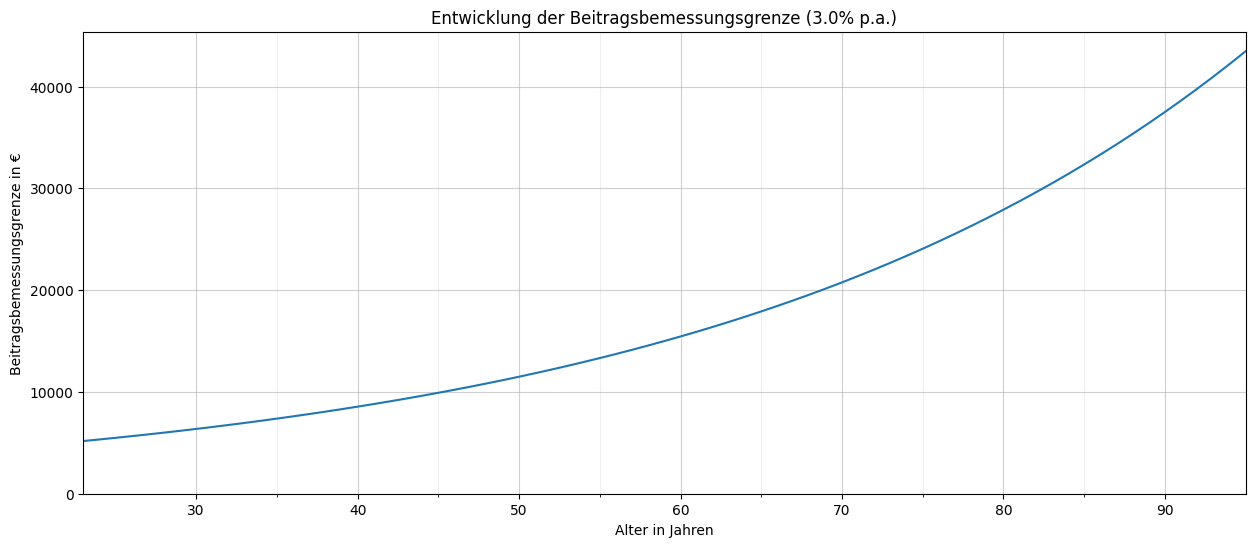

In [167]:
f, ax = plt.subplots(1)
f.set_size_inches((15, 6))

plt.plot(df['Alter'], df['GKV: Beitragsbemessungsgrenze'])

ax.set_ylim(bottom=0)
ax.set_xlim(left=EINTRITTSALTER)
ax.set_xlim(right=ENDALTER)

ax.set_title(f'Entwicklung der Beitragsbemessungsgrenze ({GKV_BEITRAGSBEMESSUNGSGRENZE_STEIGERUNG * 100}% p.a.)')
ax.set_xlabel('Alter in Jahren')
ax.set_ylabel('Beitragsbemessungsgrenze in €')

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.6)

plt.show()

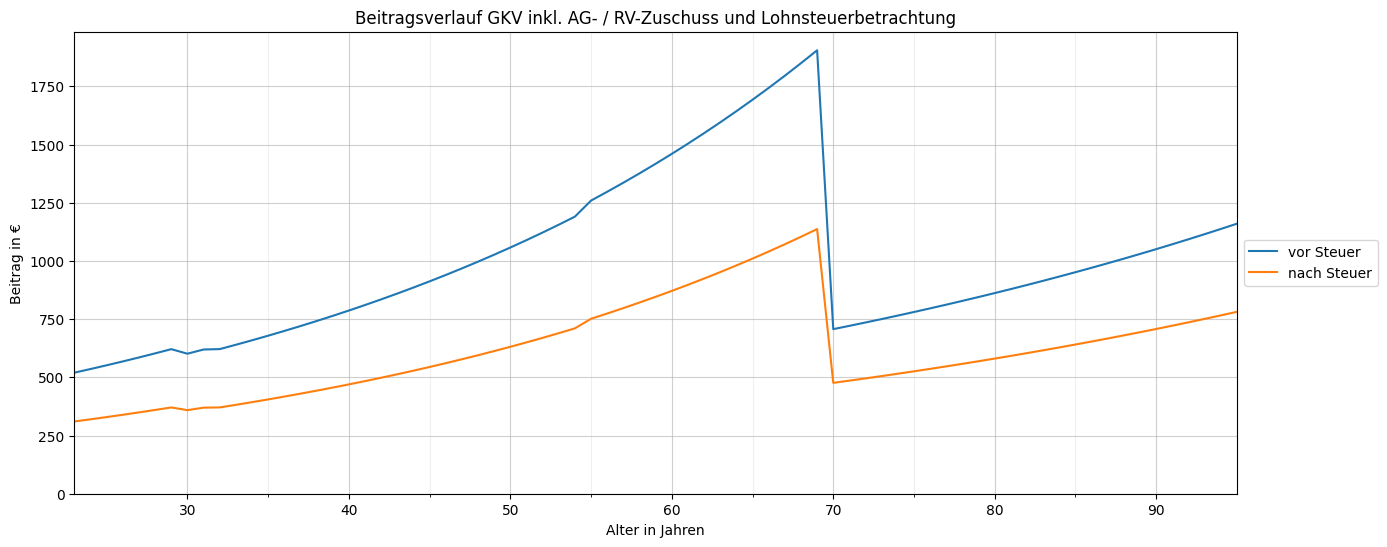

In [168]:
f, ax = plt.subplots(1)
f.set_size_inches((15, 6))

plt.plot(df['Alter'], df['GKV: Beitrag inkl. Zuschüsse exkl. LS'], label='vor Steuer')
plt.plot(df['Alter'], df['GKV: Beitrag inkl. Zuschüsse inkl. LS'], label='nach Steuer')

ax.set_ylim(bottom=0)
ax.set_xlim(left=EINTRITTSALTER)
ax.set_xlim(right=ENDALTER)

ax.set_title(f'Beitragsverlauf GKV inkl. AG- / RV-Zuschuss und Lohnsteuerbetrachtung')
ax.set_xlabel('Alter in Jahren')
ax.set_ylabel('Beitrag in €')

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.6)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## PKV Beiträge

In [169]:
def foo3(df, pkv_beitragsentlastungspaket_einzahlen_ab):
    # Kinder
    anzahl_mitversicherter_kinder = np.zeros(ENDALTER - EINTRITTSALTER + 1)
    for kind in KINDER:
        start = kind['alter_bei_geburt'] - EINTRITTSALTER
        ende = start + kind['versicherungsdauer']
        for i in range(start, ende):
            anzahl_mitversicherter_kinder[i] += 1
    df['PKV: Anzahl Kinder'] = anzahl_mitversicherter_kinder.astype(int)
    
    # Beiträge vor Lohnsteuerbetrachtung
    for tarif, konditionen in PKV_TARIFKONDITIONEN.items():
        df[f'PKV: Beitrag {tarif} exkl. LS'] = konditionen['beitrag'] * np.power(1 +  PKV_BEITRAGSSTEIGERUNG, df['Alter'] - EINTRITTSALTER) * np.where((df['Alter'] >= RENTENEINTRITTSALTER) & konditionen['wegfall_renteneintritt'], 0, 1)
    df[f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} exkl. LS'] = np.where(
        np.logical_and(pkv_beitragsentlastungspaket_einzahlen_ab <= df['Alter'], np.logical_or(PKV_BEITRAGSENTLASTUNGSPAKET_BEITRAGSFREI_AB_RENTE == False, ~df['Rentenbezug'])),
        PKV_BEITRAGSENTLASTUNGSPAKET['beitrag'] * np.power(1 + PKV_BEITRAGSSTEIGERUNG, np.minimum(PKV_BEITRAGSENTLASTUNGSPAKET_NICHT_ERHOEHEN_AB, df['Alter']) - EINTRITTSALTER),
        0
    )
    df[f'PKV: Beitrag {PKV_PV["bezeichnung"]} exkl. LS'] = PKV_PV['beitrag'] * np.power(1 + PKV_BEITRAGSSTEIGERUNG, df['Alter'] - EINTRITTSALTER)
    df['PKV: Beitrag Kinder exkl. LS'] = PKV_KINDER_BEITRAG * np.power(1 + PKV_BEITRAGSSTEIGERUNG, df['Alter'] - EINTRITTSALTER) * df['PKV: Anzahl Kinder']
    
    # gesetzliche Altersrückstellungen
    df['PKV: gesetzlicher Zuschlag zur Beitragsentlastung'] = df['Alter'] < PKV_GESETZLICHE_BEITRAGSENTLASTUNG_EINZAHLUNG_BIS
    for tarif, konditionen in PKV_TARIFKONDITIONEN.items():
        if konditionen['relevant_gesetzliche_altersrueckstellung']:
            df[f'PKV: Einzahlung Altersrückstellungen (gesetzlich) {tarif}'] = np.where(df['Alter'] <= PKV_GESETZLICHE_BEITRAGSENTLASTUNG_EINZAHLUNG_BIS, df[f'PKV: Beitrag {tarif} exkl. LS'] * PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL, 0)
            df[f'PKV: Beitrag {tarif} exkl. LS'] += df[f'PKV: Einzahlung Altersrückstellungen (gesetzlich) {tarif}']
    df['PKV: Beitrag Gesamt exkl. LS'] = df.loc[:, df.columns.str.startswith('PKV: Beitrag ') & df.columns.str.endswith(' exkl. LS') & ~df.columns.str.contains('Gesamt')].sum(axis=1)
    df['PKV: Beitrag Gesamt exkl. PV exkl. LS'] = df.loc[:, df.columns.str.startswith('PKV: Beitrag ') & df.columns.str.endswith(' exkl. LS') & ~df.columns.str.contains('Gesamt') & ~df.columns.str.contains(PKV_PV["bezeichnung"])].sum(axis=1)
    df['PKV: Einzahlung Altersrückstellungen (gesetzlich) Gesamt'] = df.loc[:, df.columns.str.startswith('PKV: Einzahlung Altersrückstellungen (gesetzlich) ') & ~df.columns.str.contains('Gesamt')].sum(axis=1)
    
    # Beitragsentlastungstarif nur solange zahlen wie man AG Zuschuss offen hat
    df[f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} exkl. LS'] = np.where(df['PKV: Beitrag Gesamt exkl. PV exkl. LS'] > df['GKV: Beitragsbemessungsgrenze'] * GKV_GESAMTBEITRAG, np.maximum(df['GKV: Beitragsbemessungsgrenze'] * GKV_GESAMTBEITRAG - (df['PKV: Beitrag Gesamt exkl. PV exkl. LS'] - df[f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} exkl. LS']), 0), df[f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} exkl. LS'])
    df['PKV: Beitrag Gesamt exkl. LS'] = df.loc[:, df.columns.str.startswith('PKV: Beitrag ') & df.columns.str.endswith(' exkl. LS') & ~df.columns.str.contains('Gesamt')].sum(axis=1)
    df['PKV: Beitrag Gesamt exkl. PV exkl. LS'] = df.loc[:, df.columns.str.startswith('PKV: Beitrag ') & df.columns.str.endswith(' exkl. LS') & ~df.columns.str.contains('Gesamt') & ~df.columns.str.contains(PKV_PV["bezeichnung"])].sum(axis=1)

    # Wertentwicklung und Auszahlung gesetzlicher Altersrückstellungen
    for tarif, konditionen in PKV_TARIFKONDITIONEN.items():
        if konditionen['relevant_gesetzliche_altersrueckstellung']:
            df[f'PKV: Auszahlung Altersrückstellungen (gesetzlich) {tarif}'] = np.where(df['Alter'] >= PKV_GESETZLICHE_BEITRAGSENTLASTUNGSPAKET_WIRKSAM_AB, df[f'PKV: Beitrag {tarif} exkl. LS'] * PKV_GESETZLICHE_BEITRAGSENTLASTUNG_REDUKTION, 0)
            df[f'PKV: Gebildete Altersrückstellungen (gesetzlich) {tarif}'] = interest((df[f'PKV: Einzahlung Altersrückstellungen (gesetzlich) {tarif}'] - df[f'PKV: Auszahlung Altersrückstellungen (gesetzlich) {tarif}']) * 12, PKV_BEITRAGSENTLASTUNG_RENDITE)
            df[f'PKV: Auszahlung Altersrückstellungen (gesetzlich) {tarif}'] = np.where(df[f'PKV: Gebildete Altersrückstellungen (gesetzlich) {tarif}'] <= 0, 0, np.minimum(df[f'PKV: Gebildete Altersrückstellungen (gesetzlich) {tarif}'] / 12, df[f'PKV: Auszahlung Altersrückstellungen (gesetzlich) {tarif}']))
    df['PKV: Auszahlung Altersrückstellungen (gesetzlich) Gesamt'] = df.loc[:, df.columns.str.startswith('PKV: Auszahlung Altersrückstellungen (gesetzlich) ') & ~df.columns.str.contains('Gesamt')].sum(axis=1)
    df['PKV: Gebildete Altersrückstellungen (gesetzlich) Gesamt'] = df.loc[:, df.columns.str.startswith('PKV: Gebildete Altersrückstellungen (gesetzlich) ') & ~df.columns.str.contains('Gesamt')].sum(axis=1)

    # Wertentwicklung und Auszahlung BET Altersrückstellungen
    df['PKV: Gebildete Altersrückstellungen (BET)'] = np.maximum(0, interest((df[f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} exkl. LS']) * 12, PKV_BEITRAGSENTLASTUNG_RENDITE))
    df['PKV: Auszahlung Altersrückstellungen (BET)'] = 0.0
    for i in range(0, len(df)):
        if df.iloc[i]['Alter'] >= PKV_BEITRAGSENTLASTUNGSPAKET_WIRKSAM_AB:
            neu_berechnetes_kapital = df.iloc[i - 1]['PKV: Gebildete Altersrückstellungen (BET)'] * (1 + PKV_BEITRAGSENTLASTUNG_RENDITE) + df.iloc[i][f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} exkl. LS'] * 12
            auszahlung_monatlich = neu_berechnetes_kapital / 12 / (PKV_BEITRAGSENTLASTUNGSPAKET_REDUKTION_BIS - df.iloc[i]['Alter'] + 1)
            df.at[i, 'PKV: Auszahlung Altersrückstellungen (BET)'] = auszahlung_monatlich
            df.at[i, 'PKV: Gebildete Altersrückstellungen (BET)'] = neu_berechnetes_kapital - auszahlung_monatlich * 12

    # Beiträge inkl. Altersrückstellung
    for tarif, konditionen in PKV_TARIFKONDITIONEN.items():
        if konditionen['relevant_gesetzliche_altersrueckstellung']:
            df[f'PKV: Beitrag {tarif} exkl. LS inkl. AR'] = df[f'PKV: Beitrag {tarif} exkl. LS'] - df[f'PKV: Auszahlung Altersrückstellungen (gesetzlich) {tarif}']
        else:
            df[f'PKV: Beitrag {tarif} exkl. LS inkl. AR'] = df[f'PKV: Beitrag {tarif} exkl. LS']
        df[f'PKV: Beitrag {tarif} exkl. LS inkl. AR'] -= (df[f'PKV: Beitrag {tarif} exkl. LS'] / df['PKV: Beitrag Gesamt exkl. LS']) * df['PKV: Auszahlung Altersrückstellungen (BET)']
    df[f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} exkl. LS inkl. AR'] = df[f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} exkl. LS'] - (df[f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} exkl. LS'] / df['PKV: Beitrag Gesamt exkl. LS']) * df['PKV: Auszahlung Altersrückstellungen (BET)']
    df[f'PKV: Beitrag {PKV_PV["bezeichnung"]} exkl. LS inkl. AR'] = df[f'PKV: Beitrag {PKV_PV["bezeichnung"]} exkl. LS'] - (df[f'PKV: Beitrag {PKV_PV["bezeichnung"]} exkl. LS'] / df['PKV: Beitrag Gesamt exkl. LS']) * df['PKV: Auszahlung Altersrückstellungen (BET)']
    df['PKV: Beitrag Kinder exkl. LS inkl. AR'] = df['PKV: Beitrag Kinder exkl. LS'] - (df['PKV: Beitrag Kinder exkl. LS'] / df['PKV: Beitrag Gesamt exkl. LS']) * df['PKV: Auszahlung Altersrückstellungen (BET)']
    df['PKV: Beitrag Gesamt exkl. LS inkl. AR'] = df.loc[:, df.columns.str.startswith('PKV: Beitrag ') & df.columns.str.endswith(' exkl. LS inkl. AR') & ~df.columns.str.contains('Gesamt')].sum(axis=1)
    df['PKV: Beitrag Gesamt exkl. PV exkl. LS inkl. AR'] = df.loc[:, df.columns.str.startswith('PKV: Beitrag ') & df.columns.str.endswith(' exkl. LS inkl. AR') & ~df.columns.str.contains('Gesamt') & ~df.columns.str.contains(PKV_PV["bezeichnung"])].sum(axis=1)
    
    # Zuschüsse AG
    df['PKV: AG Zuschuss Gesamt exkl. PV'] = np.minimum(df['GKV: Beitragsbemessungsgrenze'] * GKV_GESAMTBEITRAG, df['PKV: Beitrag Gesamt exkl. PV exkl. LS inkl. AR']) * (1 - PKV_ANTEIL_ARBEITGEBER) * (1 - df['Rentenbezug'])
    for tarif, konditionen in PKV_TARIFKONDITIONEN.items():
        df[f'PKV: AG Zuschuss {tarif}'] = (df[f'PKV: Beitrag {tarif} exkl. LS inkl. AR'] / df['PKV: Beitrag Gesamt exkl. PV exkl. LS inkl. AR']) * df['PKV: AG Zuschuss Gesamt exkl. PV'] * (1 - df['Rentenbezug'])
    df['PKV: AG Zuschuss Kinder'] = (df['PKV: Beitrag Kinder exkl. LS inkl. AR'] / df['PKV: Beitrag Gesamt exkl. PV exkl. LS inkl. AR']) * df['PKV: AG Zuschuss Gesamt exkl. PV'] * (1 - df['Rentenbezug'])
    df[f'PKV: AG Zuschuss {PKV_PV["bezeichnung"]}'] = np.minimum(df['GKV: Beitragsbemessungsgrenze'] * GKV_PV_BEITRAG, df[f'PKV: Beitrag {PKV_PV["bezeichnung"]} exkl. LS inkl. AR']) * (1 - PKV_PV_ANTEIL_ARBEITGEBER) * (1 - df['Rentenbezug'])
    df[f'PKV: AG Zuschuss {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]}'] = (df[f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} exkl. LS inkl. AR'] / df['PKV: Beitrag Gesamt exkl. PV exkl. LS inkl. AR']) * df['PKV: AG Zuschuss Gesamt exkl. PV'] * (1 - df['Rentenbezug'])
    df['PKV: AG Zuschuss Gesamt exkl. PV'] = df.loc[:, df.columns.str.startswith('PKV: AG Zuschuss ') & ~df.columns.str.contains('Gesamt') & ~df.columns.str.contains(PKV_PV["bezeichnung"])].sum(axis=1)

    # Zuschüsse RV
    df['PKV: RV Zuschuss Gesamt exkl. PV'] = np.minimum(df['Rente'] * RENTENZUSCHUSS_PKV, df['PKV: Beitrag Gesamt exkl. PV exkl. LS inkl. AR'] * RENTENZUSCHUSS_PKV_MAX_ANTEIL)
    for tarif, konditionen in PKV_TARIFKONDITIONEN.items():
        df[f'PKV: RV Zuschuss {tarif}'] = (df[f'PKV: Beitrag {tarif} exkl. LS inkl. AR'] / df['PKV: Beitrag Gesamt exkl. PV exkl. LS inkl. AR']) * df['PKV: RV Zuschuss Gesamt exkl. PV'] * df['Rentenbezug']
    df['PKV: RV Zuschuss Kinder'] = (df['PKV: Beitrag Kinder exkl. LS inkl. AR'] / df['PKV: Beitrag Gesamt exkl. PV exkl. LS inkl. AR']) * df['PKV: RV Zuschuss Gesamt exkl. PV'] * df['Rentenbezug']
    df[f'PKV: RV Zuschuss {PKV_PV["bezeichnung"]}'] = 0
    df[f'PKV: RV Zuschuss {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]}'] = (df[f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} exkl. LS inkl. AR'] / df['PKV: Beitrag Gesamt exkl. PV exkl. LS inkl. AR']) * df['PKV: RV Zuschuss Gesamt exkl. PV'] * df['Rentenbezug']
    df['PKV: RV Zuschuss Gesamt exkl. PV'] = df.loc[:, df.columns.str.startswith('PKV: RV Zuschuss ') & ~df.columns.str.contains('Gesamt') & ~df.columns.str.contains(PKV_PV["bezeichnung"])].sum(axis=1)
    
    # Beiträge inkl. Zuschüsse
    for tarif, konditionen in PKV_TARIFKONDITIONEN.items():
        df[f'PKV: Beitrag {tarif} inkl. Zuschüsse exkl. LS inkl. AR'] = df[f'PKV: Beitrag {tarif} exkl. LS inkl. AR'] - df[f'PKV: AG Zuschuss {tarif}'] - df[f'PKV: RV Zuschuss {tarif}']
    df['PKV: Beitrag Kinder inkl. Zuschüsse exkl. LS inkl. AR'] = df['PKV: Beitrag Kinder exkl. LS inkl. AR'] - df['PKV: AG Zuschuss Kinder'] - df['PKV: RV Zuschuss Kinder']
    df[f'PKV: Beitrag {PKV_PV["bezeichnung"]} inkl. Zuschüsse exkl. LS inkl. AR'] = df[f'PKV: Beitrag {PKV_PV["bezeichnung"]} exkl. LS inkl. AR'] - df[f'PKV: AG Zuschuss {PKV_PV["bezeichnung"]}'] - df[f'PKV: RV Zuschuss {PKV_PV["bezeichnung"]}']
    df[f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} inkl. Zuschüsse exkl. LS inkl. AR'] = df[f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} exkl. LS inkl. AR'] - df[f'PKV: AG Zuschuss {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]}'] - df[f'PKV: RV Zuschuss {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]}']
    df['PKV: Beitrag Gesamt inkl. Zuschüsse exkl. PV exkl. LS inkl. AR'] = df.loc[:, df.columns.str.startswith('PKV: Beitrag ') & df.columns.str.endswith(' inkl. Zuschüsse exkl. LS inkl. AR') & ~df.columns.str.contains('Gesamt') & ~df.columns.str.contains(PKV_PV["bezeichnung"])].sum(axis=1)
    df['PKV: Beitrag Gesamt inkl. Zuschüsse exkl. LS inkl. AR'] = df.loc[:, df.columns.str.startswith('PKV: Beitrag ') & df.columns.str.endswith(' inkl. Zuschüsse exkl. LS inkl. AR') & ~df.columns.str.contains('Gesamt')].sum(axis=1)
    
    # Steuererstattung
    for tarif, konditionen in PKV_TARIFKONDITIONEN.items():
        df[f'PKV: Steuererstattung {tarif}'] = df[f'PKV: Beitrag {tarif} inkl. Zuschüsse exkl. LS inkl. AR'] * konditionen['steuerlich_ansetzbar'] * df['Lohnsteuer']
    df['PKV: Steuererstattung Kinder'] = df['PKV: Beitrag Kinder inkl. Zuschüsse exkl. LS inkl. AR'] * df['Lohnsteuer']
    df[f'PKV: Steuererstattung {PKV_PV["bezeichnung"]}'] = df[f'PKV: Beitrag {PKV_PV["bezeichnung"]} inkl. Zuschüsse exkl. LS inkl. AR'] * PKV_PV['steuerlich_ansetzbar'] * df['Lohnsteuer']
    df[f'PKV: Steuererstattung {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]}'] = df[f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} inkl. Zuschüsse exkl. LS inkl. AR'] * PKV_BEITRAGSENTLASTUNGSPAKET['steuerlich_ansetzbar'] * df['Lohnsteuer']
    df['PKV: Steuererstattung Gesamt'] = df.loc[:, df.columns.str.startswith('PKV: Steuererstattung ') & ~df.columns.str.contains('Gesamt')].sum(axis=1)
    
    # Beiträge nach Steuern
    for tarif, konditionen in PKV_TARIFKONDITIONEN.items():
        df[f'PKV: Beitrag {tarif} inkl. Zuschüsse inkl. LS inkl. AR'] = df[f'PKV: Beitrag {tarif} inkl. Zuschüsse exkl. LS inkl. AR'] - df[f'PKV: Steuererstattung {tarif}']
    df['PKV: Beitrag Kinder inkl. Zuschüsse inkl. LS inkl. AR'] = df['PKV: Beitrag Kinder inkl. Zuschüsse exkl. LS inkl. AR'] - df['PKV: Steuererstattung Kinder']
    df[f'PKV: Beitrag {PKV_PV["bezeichnung"]} inkl. Zuschüsse inkl. LS inkl. AR'] = df[f'PKV: Beitrag {PKV_PV["bezeichnung"]} inkl. Zuschüsse exkl. LS inkl. AR'] - df[f'PKV: Steuererstattung {PKV_PV["bezeichnung"]}']
    df[f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} inkl. Zuschüsse inkl. LS inkl. AR'] = df[f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} inkl. Zuschüsse exkl. LS inkl. AR'] - df[f'PKV: Steuererstattung {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]}']
    df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR'] = df.loc[:, df.columns.str.startswith('PKV: Beitrag ') & df.columns.str.endswith(' inkl. Zuschüsse inkl. LS inkl. AR') & ~df.columns.str.contains('Gesamt')].sum(axis=1)

    # BRE Höhe berechnen
    df['PKV: BRE berechtigt'] = np.isin(df['Alter'], PKV_BEITRAGSRUECKERSTATTUNG_IN_ALTER)
    df['PKV: BRE beitragsfreie Jahre'] = 0
    for i in range(0, len(df)):
        beitragsfreie_jahre = 0
        for j in range(i, -1, -1):
            if df.iloc[j]['PKV: BRE berechtigt']:
                beitragsfreie_jahre += 1
            else:
                break
        df.at[i, 'PKV: BRE beitragsfreie Jahre'] = beitragsfreie_jahre
    np.random.seed(42)
    df['PKV: BRE wirtschaftliches Jahr'] = np.random.uniform(0, 1, len(df)) < PKV_BEITRAGSRUECKERSTATTUNG_WAHRSCHEINLICHKEIT
    df['PKV: BRE Gesamtbeitrag relevanter Bausteine'] = 0
    for tarif, konditionen in PKV_TARIFKONDITIONEN.items():
        if konditionen['auswirking_beitragsrueckerstattung']:
            df['PKV: BRE Gesamtbeitrag relevanter Bausteine'] += df[f'PKV: Beitrag {tarif} exkl. LS'] * df['PKV: BRE wirtschaftliches Jahr']
    df['PKV: BRE Betrag exkl. LS'] = -1 * df['PKV: BRE Gesamtbeitrag relevanter Bausteine'] * df["PKV: BRE beitragsfreie Jahre"].map(PKV_BEITRAGSRUECKERSTATTUNG_STAFFELUNG).fillna(list(PKV_BEITRAGSRUECKERSTATTUNG_STAFFELUNG.values())[-1]) / 12
    df['PKV: BRE Betrag inkl. LS'] = df['PKV: BRE Betrag exkl. LS'] * (1 - df['Lohnsteuer'])
    
    # Beiträge nach BRE
    df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE'] = df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR'] + df['PKV: BRE Betrag inkl. LS']
    
    return df

df = foo3(df, PKV_BEITRAGSENTLASTUNGSPAKET_EINZAHLEN_AB)
df.loc[:, ~df.columns.str.startswith('GKV: ')]

,Jahr,Alter,Inflation seit 2024,Rentenbezug,Einkommen,Rente,Lohnsteuer,PKV: Anzahl Kinder,PKV: Beitrag A 80/100 exkl. LS,PKV: Beitrag K 20 exkl. LS,PKV: Beitrag K/S exkl. LS,PKV: Beitrag Z 100/80 exkl. LS,PKV: Beitrag AK (Variante AK-E) exkl. LS,PKV: Beitrag KTV 6 155€ exkl. LS,PKV: Beitrag PBE 2.0 350€ exkl. LS,PKV: Beitrag PVN exkl. LS,PKV: Beitrag Kinder exkl. LS,PKV: gesetzlicher Zuschlag zur Beitragsentlastung,PKV: Einzahlung Altersrückstellungen (gesetzlich) A 80/100,PKV: Einzahlung Altersrückstellungen (gesetzlich) K 20,PKV: Einzahlung Altersrückstellungen (gesetzlich) K/S,PKV: Einzahlung Altersrückstellungen (gesetzlich) Z 100/80,PKV: Beitrag Gesamt exkl. LS,PKV: Beitrag Gesamt exkl. PV exkl. LS,PKV: Einzahlung Altersrückstellungen (gesetzlich) Gesamt,PKV: Auszahlung Altersrückstellungen (gesetzlich) A 80/100,PKV: Gebildete Altersrückstellungen (gesetzlich) A 80/100,PKV: Auszahlung Altersrückstellungen (gesetzlich) K 20,PKV: Gebildete Altersrückstellungen (gesetzlich) K 20,PKV: Auszahlung Altersrückstellungen (gesetzlich) K/S,PKV: Gebildete Altersrückstellungen (gesetzlich) K/S,PKV: Auszahlung Altersrückstellungen (gesetzlich) Z 100/80,PKV: Gebildete Altersrückstellungen (gesetzlich) Z 100/80,PKV: Auszahlung Altersrückstellungen (gesetzlich) Gesamt,PKV: Gebildete Altersrückstellungen (gesetzlich) Gesamt,PKV: Gebildete Altersrückstellungen (BET),PKV: Auszahlung Altersrückstellungen (BET),PKV: Beitrag A 80/100 exkl. LS inkl. AR,PKV: Beitrag K 20 exkl. LS inkl. AR,PKV: Beitrag K/S exkl. LS inkl. AR,PKV: Beitrag Z 100/80 exkl. LS inkl. AR,PKV: Beitrag AK (Variante AK-E) exkl. LS inkl. AR,PKV: Beitrag KTV 6 155€ exkl. LS inkl. AR,PKV: Beitrag PBE 2.0 350€ exkl. LS inkl. AR,PKV: Beitrag PVN exkl. LS inkl. AR,PKV: Beitrag Kinder exkl. LS inkl. AR,PKV: Beitrag Gesamt exkl. LS inkl. AR,PKV: Beitrag Gesamt exkl. PV exkl. LS inkl. AR,PKV: AG Zuschuss Gesamt exkl. PV,PKV: AG Zuschuss A 80/100,PKV: AG Zuschuss K 20,PKV: AG Zuschuss K/S,PKV: AG Zuschuss Z 100/80,PKV: AG Zuschuss AK (Variante AK-E),PKV: AG Zuschuss KTV 6 155€,PKV: AG Zuschuss Kinder,PKV: AG Zuschuss PVN,PKV: AG Zuschuss PBE 2.0 350€,PKV: RV Zuschuss Gesamt exkl. PV,PKV: RV Zuschuss A 80/100,PKV: RV Zuschuss K 20,PKV: RV Zuschuss K/S,PKV: RV Zuschuss Z 100/80,PKV: RV Zuschuss AK (Variante AK-E),PKV: RV Zuschuss KTV 6 155€,PKV: RV Zuschuss Kinder,PKV: RV Zuschuss PVN,PKV: RV Zuschuss PBE 2.0 350€,PKV: Beitrag A 80/100 inkl. Zuschüsse exkl. LS inkl. AR,PKV: Beitrag K 20 inkl. Zuschüsse exkl. LS inkl. AR,PKV: Beitrag K/S inkl. Zuschüsse exkl. LS inkl. AR,PKV: Beitrag Z 100/80 inkl. Zuschüsse exkl. LS inkl. AR,PKV: Beitrag AK (Variante AK-E) inkl. Zuschüsse exkl. LS inkl. AR,PKV: Beitrag KTV 6 155€ inkl. Zuschüsse exkl. LS inkl. AR,PKV: Beitrag Kinder inkl. Zuschüsse exkl. LS inkl. AR,PKV: Beitrag PVN inkl. Zuschüsse exkl. LS inkl. AR,PKV: Beitrag PBE 2.0 350€ inkl. Zuschüsse exkl. LS inkl. AR,PKV: Beitrag Gesamt inkl. Zuschüsse exkl. PV exkl. LS inkl. AR,PKV: Beitrag Gesamt inkl. Zuschüsse exkl. LS inkl. AR,PKV: Steuererstattung A 80/100,PKV: Steuererstattung K 20,PKV: Steuererstattung K/S,PKV: Steuererstattung Z 100/80,PKV: Steuererstattung AK (Variante AK-E),PKV: Steuererstattung KTV 6 155€,PKV: Steuererstattung Kinder,PKV: Steuererstattung PVN,PKV: Steuererstattung PBE 2.0 350€,PKV: Steuererstattung Gesamt,PKV: Beitrag A 80/100 inkl. Zuschüsse inkl. LS inkl. AR,PKV: Beitrag K 20 inkl. Zuschüsse inkl. LS inkl. AR,PKV: Beitrag K/S inkl. Zuschüsse inkl. LS inkl. AR,PKV: Beitrag Z 100/80 inkl. Zuschüsse inkl. LS inkl. AR,PKV: Beitrag AK (Variante AK-E) inkl. Zuschüsse inkl. LS inkl. AR,PKV: Beitrag KTV 6 155€ inkl. Zuschüsse inkl. LS inkl. AR,PKV: Beitrag Kinder inkl. Zuschüsse inkl. LS inkl. AR,PKV: Beitrag PVN inkl. Zuschüsse inkl. LS inkl. AR,PKV: Beitrag PBE 2.0 350€ inkl. Zuschüsse inkl. LS inkl. AR,PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR,PKV: BRE berechtigt,PKV: BRE beitragsfreie Jahre,PKV: BRE wirtschaftliches Jahr,PKV: BRE Gesamtbeitrag relevanter Ba

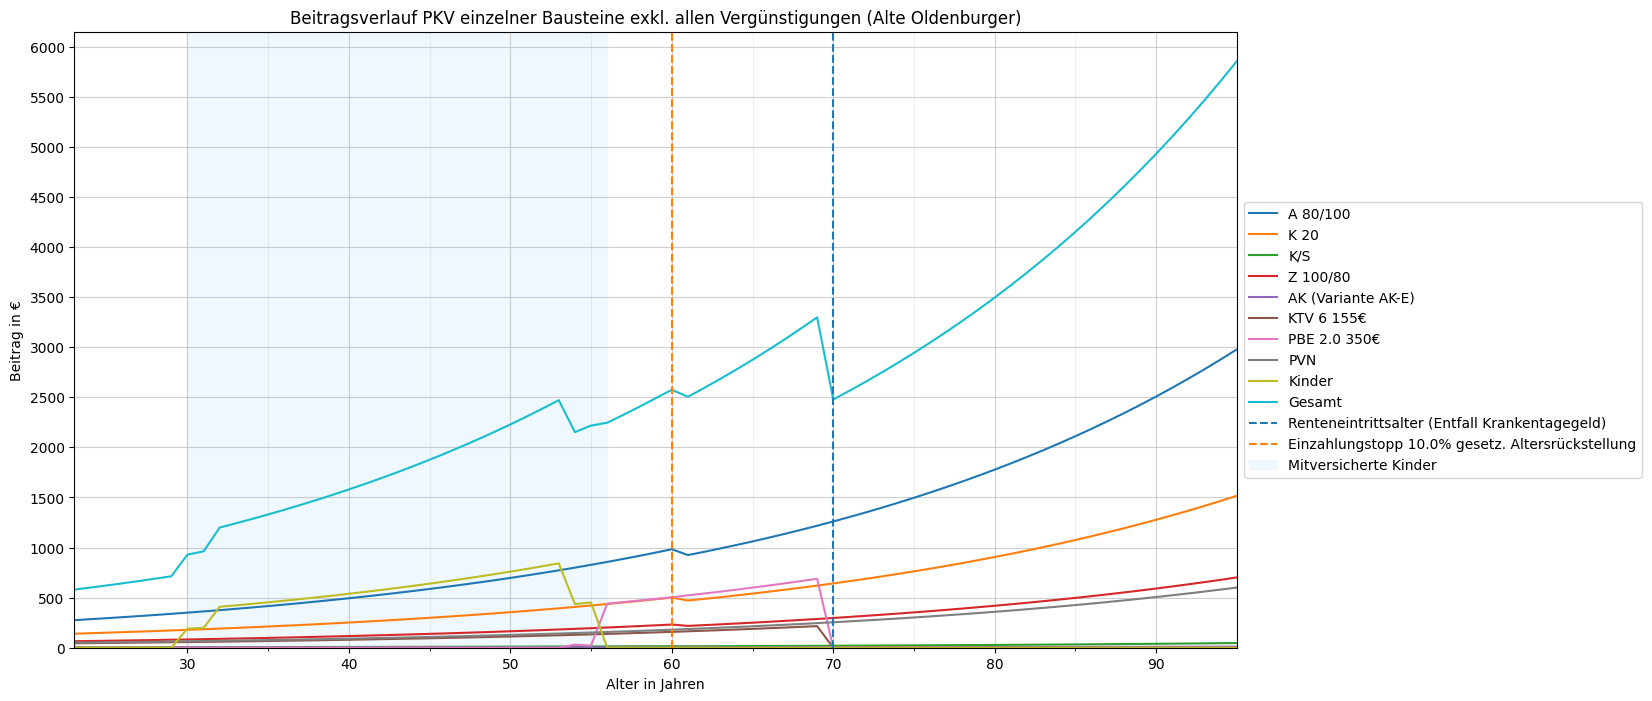

In [170]:
f, ax = plt.subplots(1)
f.set_size_inches((15, 8))

to_plot = df.loc[:, df.columns.str.startswith('PKV: Beitrag ') & df.columns.str.endswith(' exkl. LS') & ~df.columns.str.contains('exkl. PV') & ~(df.sum(axis=0).eq(0))].columns
for col in to_plot:
    plt.plot(df['Alter'], df[col], label=col.replace('PKV: Beitrag ', '').replace(' exkl. LS', ''))

ax.axvline(x=RENTENEINTRITTSALTER, label="Renteneintrittsalter (Entfall Krankentagegeld)", linestyle='dashed', color='tab:blue')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNG_EINZAHLUNG_BIS, label=f'Einzahlungstopp {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:orange')

if alter_wenn_erstes_kind != 1000:
    ax.axvspan(alter_wenn_erstes_kind, alter_wenn_letztes_kind, color='aliceblue', label='Mitversicherte Kinder')

ax.set_ylim(bottom=0)
ax.set_xlim(left=EINTRITTSALTER)
ax.set_xlim(right=ENDALTER)

ax.set_title(f'Beitragsverlauf PKV einzelner Bausteine exkl. allen Vergünstigungen ({PKV_VERSICHERUNG})')
ax.set_xlabel('Alter in Jahren')
ax.set_ylabel('Beitrag in €')

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.6)

plt.gca().yaxis.set_major_locator(plt.MultipleLocator(500))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

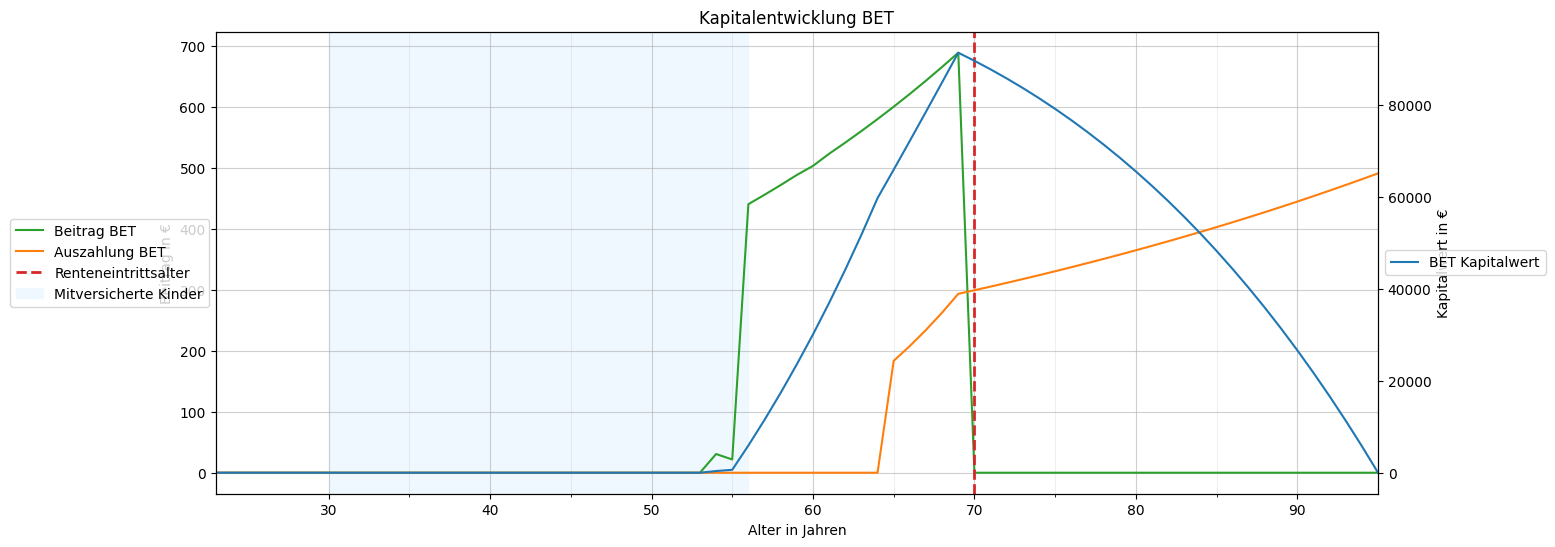

In [171]:
f, ax1 = plt.subplots(1)
f.set_size_inches((15, 6))
ax2 = ax1.twinx()

ax1.plot(df['Alter'], df[f'PKV: Beitrag {PKV_BEITRAGSENTLASTUNGSPAKET["bezeichnung"]} exkl. LS'], label='Beitrag BET', color='tab:green')
ax1.plot(df['Alter'], df['PKV: Auszahlung Altersrückstellungen (BET)'], label='Auszahlung BET', color='tab:orange')

ax1.axvline(x=RENTENEINTRITTSALTER, label="Renteneintrittsalter", linestyle='dashed', color='tab:red', linewidth=2)

if alter_wenn_erstes_kind != 1000:
    ax1.axvspan(alter_wenn_erstes_kind, alter_wenn_letztes_kind, color='aliceblue', label='Mitversicherte Kinder')

ax2.plot(df['Alter'], df['PKV: Gebildete Altersrückstellungen (BET)'], label='BET Kapitalwert', color='tab:blue')

ax1.set_xlim(left=EINTRITTSALTER)
ax1.set_xlim(right=ENDALTER)

ax1.set_title('Kapitalentwicklung BET')
ax1.set_xlabel('Alter in Jahren')
ax1.set_ylabel('Beitrag in €')
ax2.set_ylabel('Kapitalwert in €')

ax1.set_xticks(major_ticks)
ax1.set_xticks(minor_ticks, minor=True)
ax1.grid(which='minor', alpha=0.2)
ax1.grid(which='major', alpha=0.6)

ax1.legend(loc='center right', bbox_to_anchor=(0, 0.5))
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

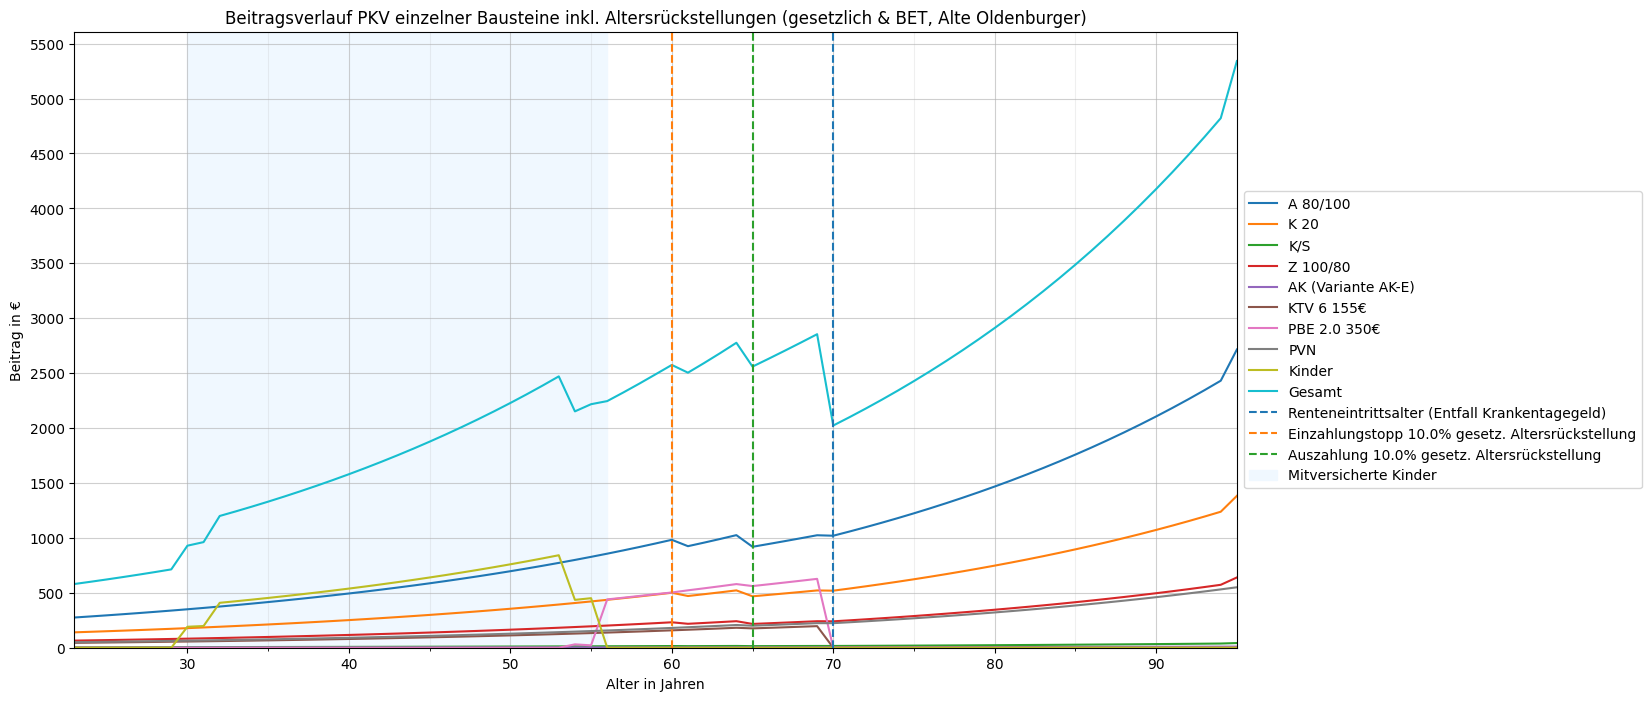

In [172]:
f, ax = plt.subplots(1)
f.set_size_inches((15, 8))

gesetzliche_altersruckstellungen_verbraucht = ENDALTER
for i in df['PKV: Gebildete Altersrückstellungen (gesetzlich) Gesamt'][::-1]:
    if i > 0:
        break
    gesetzliche_altersruckstellungen_verbraucht -= 1

to_plot = df.loc[:, df.columns.str.startswith('PKV: Beitrag ') & df.columns.str.endswith(' exkl. LS inkl. AR') & ~df.columns.str.contains('inkl. Zuschüsse') & ~df.columns.str.contains('exkl. PV') & ~(df.sum(axis=0).eq(0))].columns
for col in to_plot:
    plt.plot(df['Alter'], df[col], label=col.replace('PKV: Beitrag ', '').replace(' exkl. LS inkl. AR', ''))

ax.axvline(x=RENTENEINTRITTSALTER, label="Renteneintrittsalter (Entfall Krankentagegeld)", linestyle='dashed', color='tab:blue')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNG_EINZAHLUNG_BIS, label=f'Einzahlungstopp {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:orange')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNGSPAKET_WIRKSAM_AB, label=f'Auszahlung {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:green')
if gesetzliche_altersruckstellungen_verbraucht != ENDALTER:
    ax.axvline(x=gesetzliche_altersruckstellungen_verbraucht, label='gestz. Altersrückstellungen verbraucht', linestyle='dashed', color='tab:red')

if alter_wenn_erstes_kind != 1000:
    ax.axvspan(alter_wenn_erstes_kind, alter_wenn_letztes_kind, color='aliceblue', label='Mitversicherte Kinder')

ax.set_ylim(bottom=0)
ax.set_xlim(left=EINTRITTSALTER)
ax.set_xlim(right=ENDALTER)

ax.set_title(f'Beitragsverlauf PKV einzelner Bausteine inkl. Altersrückstellungen (gesetzlich & BET, {PKV_VERSICHERUNG})')
ax.set_xlabel('Alter in Jahren')
ax.set_ylabel('Beitrag in €')

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.6)

plt.gca().yaxis.set_major_locator(plt.MultipleLocator(500))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

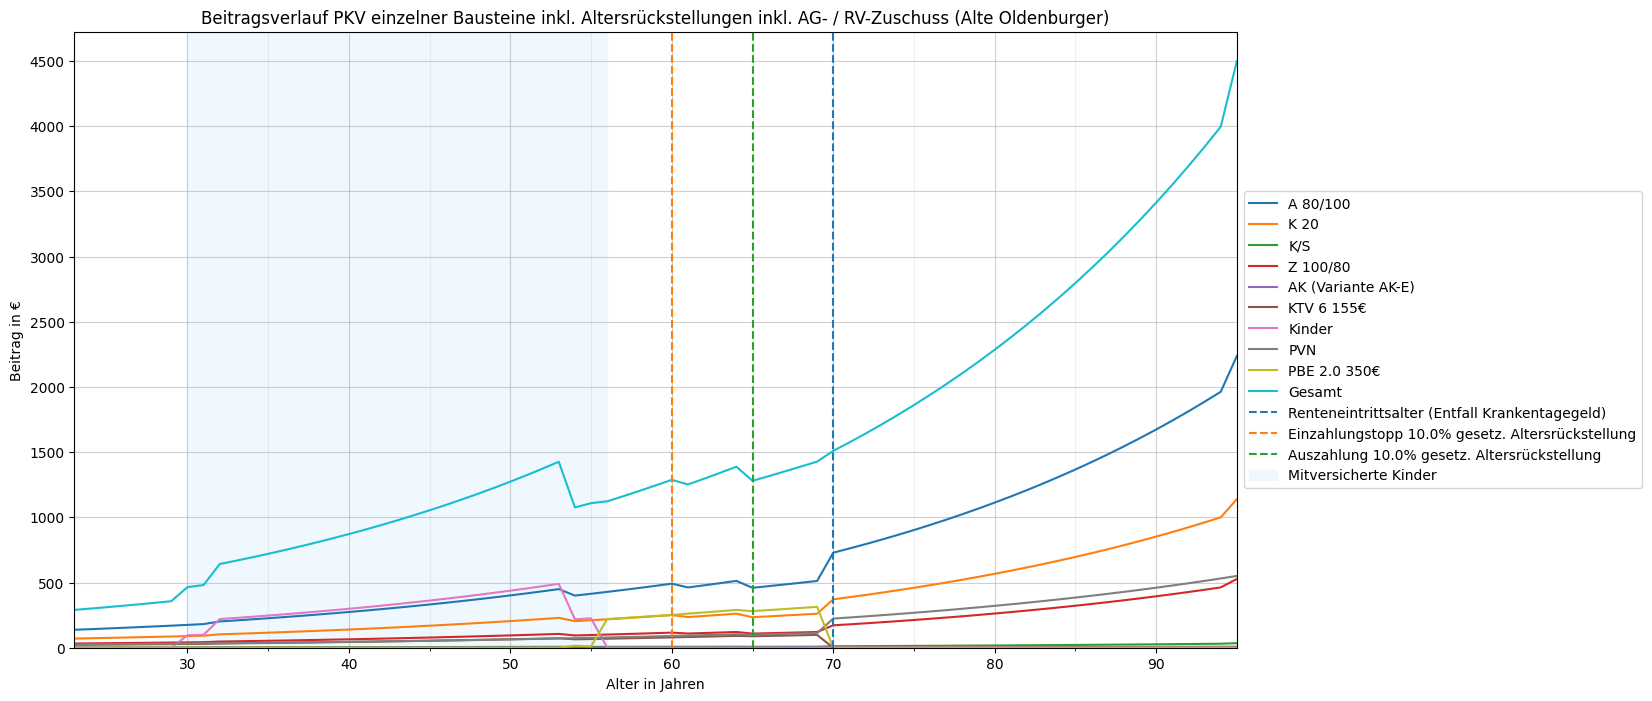

In [173]:
f, ax = plt.subplots(1)
f.set_size_inches((15, 8))

to_plot = df.loc[:, df.columns.str.startswith('PKV: Beitrag ') & df.columns.str.endswith(' inkl. Zuschüsse exkl. LS inkl. AR') & ~df.columns.str.contains('exkl. PV') & ~(df.sum(axis=0).eq(0))].columns
for col in to_plot:
    plt.plot(df['Alter'], df[col], label=col.replace('PKV: Beitrag ', '').replace(' inkl. Zuschüsse exkl. LS inkl. AR', ''))

ax.axvline(x=RENTENEINTRITTSALTER, label="Renteneintrittsalter (Entfall Krankentagegeld)", linestyle='dashed', color='tab:blue')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNG_EINZAHLUNG_BIS, label=f'Einzahlungstopp {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:orange')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNGSPAKET_WIRKSAM_AB, label=f'Auszahlung {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:green')
if gesetzliche_altersruckstellungen_verbraucht != ENDALTER:
    ax.axvline(x=gesetzliche_altersruckstellungen_verbraucht, label='gestz. Altersrückstellungen verbraucht', linestyle='dashed', color='tab:red')

if alter_wenn_erstes_kind != 1000:
    ax.axvspan(alter_wenn_erstes_kind, alter_wenn_letztes_kind, color='aliceblue', label='Mitversicherte Kinder')

ax.set_ylim(bottom=0)
ax.set_xlim(left=EINTRITTSALTER)
ax.set_xlim(right=ENDALTER)

ax.set_title(f'Beitragsverlauf PKV einzelner Bausteine inkl. Altersrückstellungen inkl. AG- / RV-Zuschuss ({PKV_VERSICHERUNG})')
ax.set_xlabel('Alter in Jahren')
ax.set_ylabel('Beitrag in €')

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.6)

plt.gca().yaxis.set_major_locator(plt.MultipleLocator(500))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

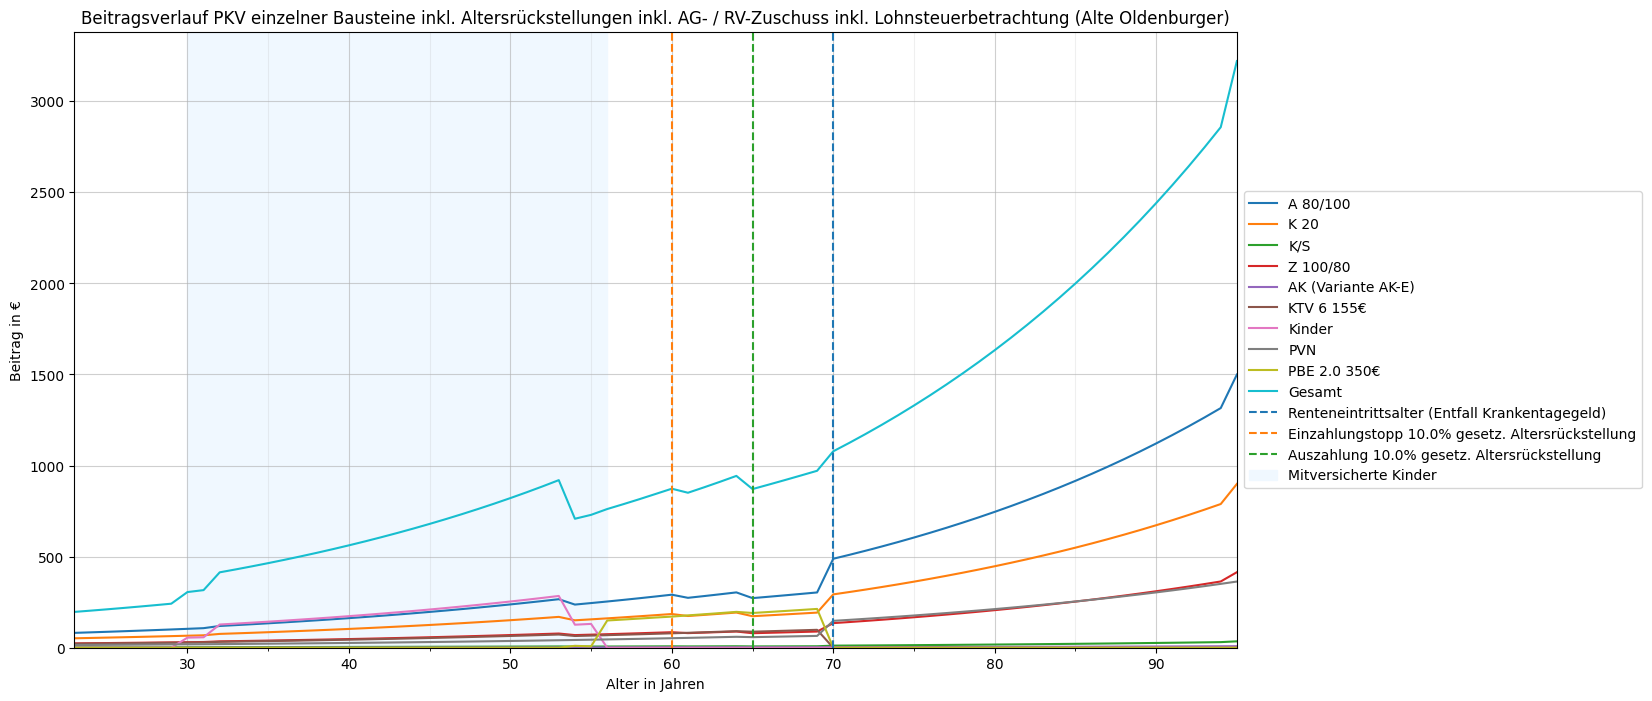

In [174]:
f, ax = plt.subplots(1)
f.set_size_inches((15, 8))

to_plot = df.loc[:, df.columns.str.startswith('PKV: Beitrag ') & df.columns.str.endswith(' inkl. Zuschüsse inkl. LS inkl. AR') & ~df.columns.str.contains('exkl. PV') & ~(df.sum(axis=0).eq(0))].columns
for col in to_plot:
    plt.plot(df['Alter'], df[col], label=col.replace('PKV: Beitrag ', '').replace(' inkl. Zuschüsse inkl. LS inkl. AR', ''))

ax.axvline(x=RENTENEINTRITTSALTER, label="Renteneintrittsalter (Entfall Krankentagegeld)", linestyle='dashed', color='tab:blue')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNG_EINZAHLUNG_BIS, label=f'Einzahlungstopp {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:orange')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNGSPAKET_WIRKSAM_AB, label=f'Auszahlung {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:green')
if gesetzliche_altersruckstellungen_verbraucht != ENDALTER:
    ax.axvline(x=gesetzliche_altersruckstellungen_verbraucht, label='gestz. Altersrückstellungen verbraucht', linestyle='dashed', color='tab:red')

if alter_wenn_erstes_kind != 1000:
    ax.axvspan(alter_wenn_erstes_kind, alter_wenn_letztes_kind, color='aliceblue', label='Mitversicherte Kinder')

ax.set_ylim(bottom=0)
ax.set_xlim(left=EINTRITTSALTER)
ax.set_xlim(right=ENDALTER)

ax.set_title(f'Beitragsverlauf PKV einzelner Bausteine inkl. Altersrückstellungen inkl. AG- / RV-Zuschuss inkl. Lohnsteuerbetrachtung ({PKV_VERSICHERUNG})')
ax.set_xlabel('Alter in Jahren')
ax.set_ylabel('Beitrag in €')

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.6)

plt.gca().yaxis.set_major_locator(plt.MultipleLocator(500))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

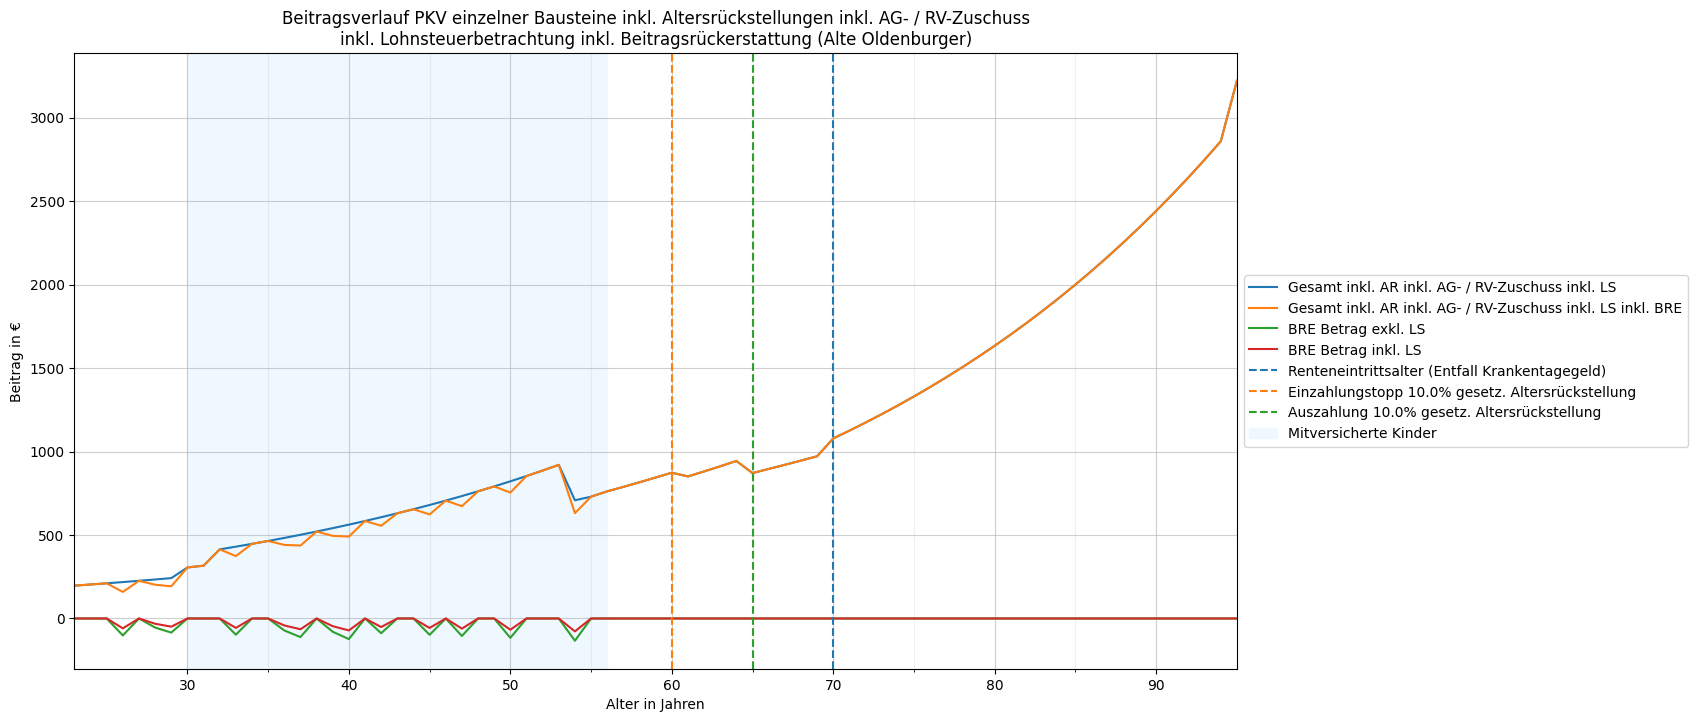

In [175]:
f, ax = plt.subplots(1)
f.set_size_inches((15, 8))

plt.plot(df['Alter'], df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR'], label='Gesamt inkl. AR inkl. AG- / RV-Zuschuss inkl. LS')
plt.plot(df['Alter'], df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE'], label='Gesamt inkl. AR inkl. AG- / RV-Zuschuss inkl. LS inkl. BRE')
plt.plot(df['Alter'], df['PKV: BRE Betrag exkl. LS'], label='BRE Betrag exkl. LS')
plt.plot(df['Alter'], df['PKV: BRE Betrag inkl. LS'], label='BRE Betrag inkl. LS')

ax.axvline(x=RENTENEINTRITTSALTER, label="Renteneintrittsalter (Entfall Krankentagegeld)", linestyle='dashed', color='tab:blue')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNG_EINZAHLUNG_BIS, label=f'Einzahlungstopp {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:orange')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNGSPAKET_WIRKSAM_AB, label=f'Auszahlung {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:green')
if gesetzliche_altersruckstellungen_verbraucht != ENDALTER:
    ax.axvline(x=gesetzliche_altersruckstellungen_verbraucht, label='gestz. Altersrückstellungen verbraucht', linestyle='dashed', color='tab:red')

if alter_wenn_erstes_kind != 1000:
    ax.axvspan(alter_wenn_erstes_kind, alter_wenn_letztes_kind, color='aliceblue', label='Mitversicherte Kinder')

ax.set_xlim(left=EINTRITTSALTER)
ax.set_xlim(right=ENDALTER)

ax.set_title(f'Beitragsverlauf PKV einzelner Bausteine inkl. Altersrückstellungen inkl. AG- / RV-Zuschuss\ninkl. Lohnsteuerbetrachtung inkl. Beitragsrückerstattung ({PKV_VERSICHERUNG})')
ax.set_xlabel('Alter in Jahren')
ax.set_ylabel('Beitrag in €')

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.6)

plt.gca().yaxis.set_major_locator(plt.MultipleLocator(500))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

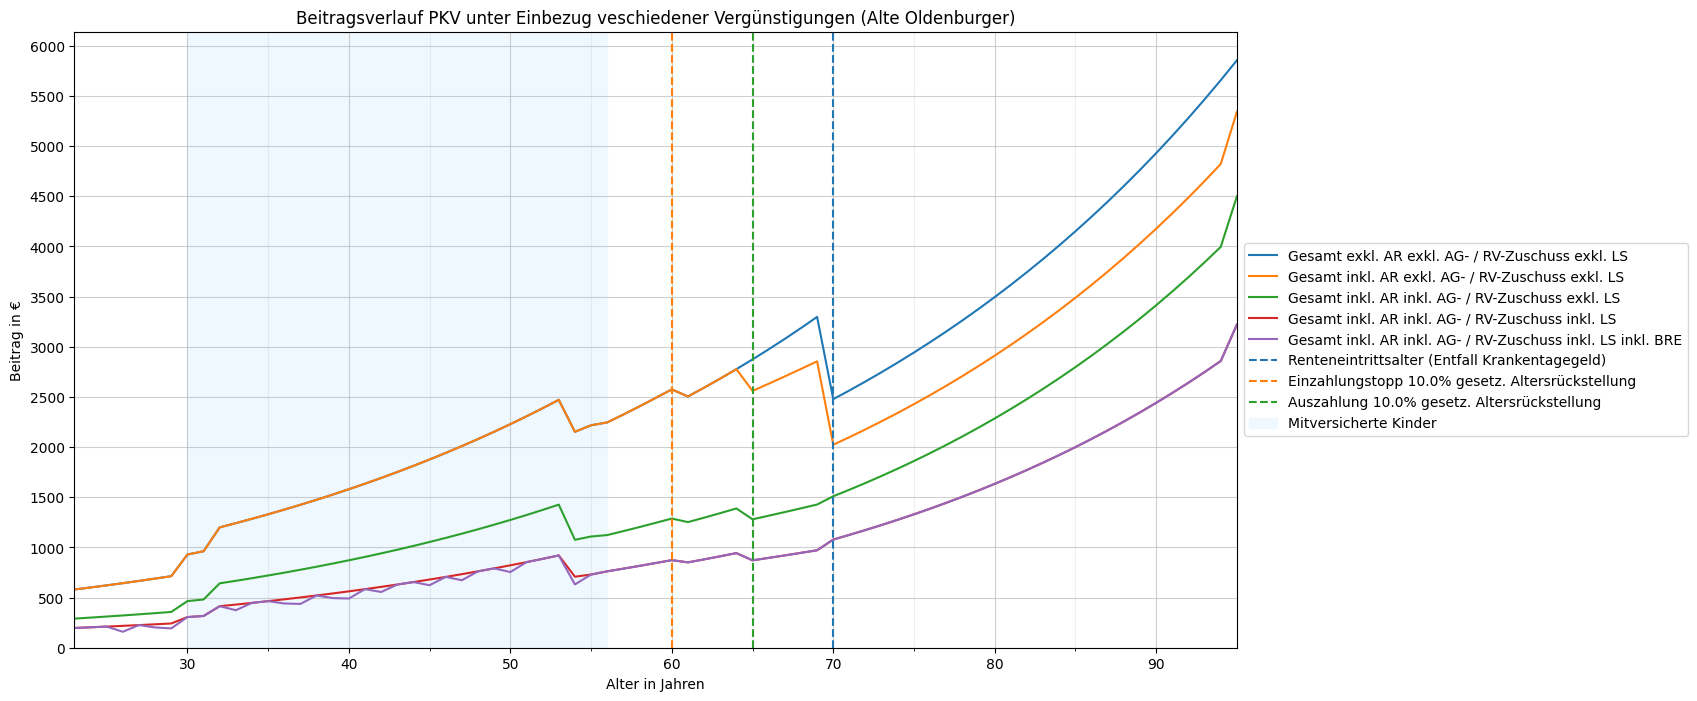

In [176]:
f, ax = plt.subplots(1)
f.set_size_inches((15, 8))

plt.plot(df['Alter'], df['PKV: Beitrag Gesamt exkl. LS'], label='Gesamt exkl. AR exkl. AG- / RV-Zuschuss exkl. LS')
plt.plot(df['Alter'], df['PKV: Beitrag Gesamt exkl. LS inkl. AR'], label='Gesamt inkl. AR exkl. AG- / RV-Zuschuss exkl. LS')
plt.plot(df['Alter'], df['PKV: Beitrag Gesamt inkl. Zuschüsse exkl. LS inkl. AR'], label='Gesamt inkl. AR inkl. AG- / RV-Zuschuss exkl. LS')
plt.plot(df['Alter'], df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR'], label='Gesamt inkl. AR inkl. AG- / RV-Zuschuss inkl. LS')
plt.plot(df['Alter'], df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE'], label='Gesamt inkl. AR inkl. AG- / RV-Zuschuss inkl. LS inkl. BRE')

ax.axvline(x=RENTENEINTRITTSALTER, label="Renteneintrittsalter (Entfall Krankentagegeld)", linestyle='dashed', color='tab:blue')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNG_EINZAHLUNG_BIS, label=f'Einzahlungstopp {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:orange')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNGSPAKET_WIRKSAM_AB, label=f'Auszahlung {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:green')
if gesetzliche_altersruckstellungen_verbraucht != ENDALTER:
    ax.axvline(x=gesetzliche_altersruckstellungen_verbraucht, label='gestz. Altersrückstellungen verbraucht', linestyle='dashed', color='tab:red')

if alter_wenn_erstes_kind != 1000:
    ax.axvspan(alter_wenn_erstes_kind, alter_wenn_letztes_kind, color='aliceblue', label='Mitversicherte Kinder')

ax.set_ylim(bottom=0)
ax.set_xlim(left=EINTRITTSALTER)
ax.set_xlim(right=ENDALTER)

ax.set_title(f'Beitragsverlauf PKV unter Einbezug veschiedener Vergünstigungen ({PKV_VERSICHERUNG})')
ax.set_xlabel('Alter in Jahren')
ax.set_ylabel('Beitrag in €')

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.6)

plt.gca().yaxis.set_major_locator(plt.MultipleLocator(500))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Vermögensaufbau

In [177]:
def foo4(df, on_top_investieren_betrag):
    df['Ersparnis PKV vs. GKV'] = df['GKV: Beitrag inkl. Zuschüsse inkl. LS'] - df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE']
    df['Zusätzlich investieren'] = np.where(df['Alter'] <= ON_TOP_INVESTIEREN_BIS, on_top_investieren_betrag * np.power(1 + ON_TOP_INVESTIEREN_BEITRAGSAUTOMATIK, df['Alter'] - EINTRITTSALTER), 0)
    df['ETF Auszahlung (vor Steuer)'] = np.where(df['Alter'] >= REDUKTION_ETF_AB, df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE'] * REDUKTION_ETF / (1 - KAPITALERTRAGSSTEUER), 0)
    df['Gebildete Ersparnisse in ETF'] = np.maximum(0, interest((np.maximum(df['Ersparnis PKV vs. GKV'], 0) + df['Zusätzlich investieren'] - df['ETF Auszahlung (vor Steuer)']) * 12, RENDITE_KAPITALMARKT))
    df['ETF Auszahlung (vor Steuer)'] = np.where(df['Gebildete Ersparnisse in ETF'] == 0, 0, np.minimum(df['Gebildete Ersparnisse in ETF'] / 12, df['ETF Auszahlung (vor Steuer)']))
    df['ETF Auszahlung (nach Steuer)'] = df['ETF Auszahlung (vor Steuer)'] * (1 - KAPITALERTRAGSSTEUER)
    
    df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE inkl. ETF'] = df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE'] + np.maximum(df['Ersparnis PKV vs. GKV'], 0) + df['Zusätzlich investieren'] - df['ETF Auszahlung (nach Steuer)']
    
    df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE inkl. ETF inflationsbereinigt'] = df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE inkl. ETF'] / df[f'Inflation seit {JAHR}']
    df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE inflationsbereinigt'] = df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE'] / df[f'Inflation seit {JAHR}']
    df['GKV: Beitrag inkl. Zuschüsse inkl. LS inflationsbereinigt'] = df['GKV: Beitrag inkl. Zuschüsse inkl. LS'] / df[f'Inflation seit {JAHR}']

    return df

df = foo4(df, ON_TOP_INVESTIEREN_BETRAG)

df[[
    'Alter',
    'Jahr',
    'Einkommen',
    'Rente',
    f'Inflation seit {JAHR}',
    'PKV: Anzahl Kinder',
    'GKV: Beitrag inkl. Zuschüsse inkl. LS',
    'PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE',
    'Ersparnis PKV vs. GKV',
    'Zusätzlich investieren',
    'Gebildete Ersparnisse in ETF',
    'ETF Auszahlung (vor Steuer)',
    'ETF Auszahlung (nach Steuer)',
    'PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE inkl. ETF',
    'PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE inkl. ETF inflationsbereinigt',
    'PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE inflationsbereinigt',
    'GKV: Beitrag inkl. Zuschüsse inkl. LS inflationsbereinigt',
]]

,Alter,Jahr,Einkommen,Rente,Inflation seit 2024,PKV: Anzahl Kinder,GKV: Beitrag inkl. Zuschüsse inkl. LS,PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE,Ersparnis PKV vs. GKV,Zusätzlich investieren,Gebildete Ersparnisse in ETF,ETF Auszahlung (vor Steuer),ETF Auszahlung (nach Steuer),PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE inkl. ETF,PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE inkl. ETF inflationsbereinigt,PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE inflationsbereinigt,GKV: Beitrag inkl. Zuschüsse inkl. LS inflationsbereinigt
0,23,2024,"3,300.0000",0.0000,1.0000,0,310.3882,196.6440,113.7442,75.0000,"2,264.9306",0.0000,0.0000,385.3882,385.3882,196.6440,310.3882
1,24,2025,"3,399.0000",0.0000,1.0250,0,319.6999,203.5265,116.1733,76.5000,"4,690.2570",0.0000,0.0000,396.1999,386.5365,198.5625,311.9023
2,25,2026,"3,500.9700",0.0000,1.0506,0,329.2909,210.6500,118.6409,78.0300,"7,284.8205",0.0000,0.0000,407.3209,387.6939,200.4997,313.4238
3,26,2027,"3,605.9991",0.0000,1.0769,0,339.1696,159.0382,180.1314,79.5906,"10,765.7258",0.0000,0.0000,418.7602,388.8605,147.6827,314.9527
4,27,2028,"3,714.1791",0.0000,1.1038,0,349.3447,225.6535,123.6912,81.1824,"13,762.4949",0.0000,0.0000,430.5271,390.0363,204.4310,316.4890
5,28,2029,"3,825.6044",0.0000,1.1314,0,359.8250,201.9585,157.8665,82.8061,"17,338.6903",0.0000,0.0000,442.6311,391.2214,178.5019,318.0329
6,29,2030,"3,940.3726",0.0000,1.1597,0,370.6198,192.6778,177.9420,84.4622,"21,354.4750",0.0000,0.0000,455.0819,392.4157,166.1454,319.5843
7,30,2031,"4,058.5838",0.0000,1.1887,1,358.9480,305.5302,53.4178,86.1514,"24,097.0291",0.0000,0.0000,445.0994,374.4467,257.0320,301.9705
8,31,2032,"4,180.3413",0.0000,1.2184,1,369.7165,316.2238,53.4927,87.8745,"26,998.2858",0.0000,0.0000,457.5909,375.5662,259.5396,303.4435
9,32,2033,"4,305.7515",0.0000,1.2489,2,370.7337,413.9049,-43.1713,89.6319,"29,423.7834",0.0000,0.0000,503.5369,403.1963,331.4254,296.8570


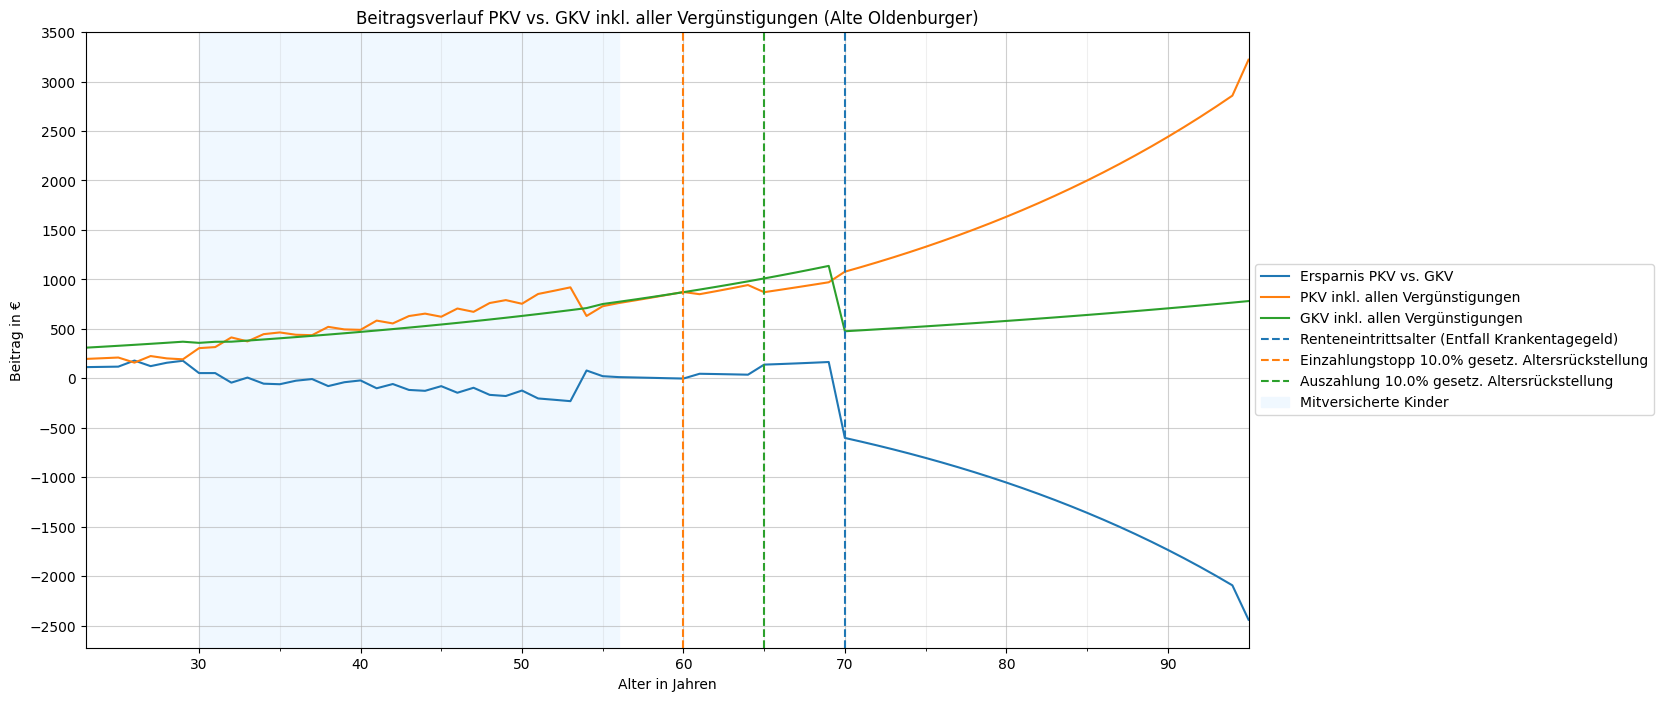

In [178]:
f, ax = plt.subplots(1)
f.set_size_inches((15, 8))

plt.plot(df['Alter'], df['Ersparnis PKV vs. GKV'], label='Ersparnis PKV vs. GKV')
plt.plot(df['Alter'], df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE'], label='PKV inkl. allen Vergünstigungen')
plt.plot(df['Alter'], df['GKV: Beitrag inkl. Zuschüsse inkl. LS'], label='GKV inkl. allen Vergünstigungen')

ax.axvline(x=RENTENEINTRITTSALTER, label="Renteneintrittsalter (Entfall Krankentagegeld)", linestyle='dashed', color='tab:blue')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNG_EINZAHLUNG_BIS, label=f'Einzahlungstopp {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:orange')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNGSPAKET_WIRKSAM_AB, label=f'Auszahlung {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:green')
if gesetzliche_altersruckstellungen_verbraucht != ENDALTER:
    ax.axvline(x=gesetzliche_altersruckstellungen_verbraucht, label='gestz. Altersrückstellungen verbraucht', linestyle='dashed', color='tab:red')

if alter_wenn_erstes_kind != 1000:
    ax.axvspan(alter_wenn_erstes_kind, alter_wenn_letztes_kind, color='aliceblue', label='Mitversicherte Kinder')

ax.set_xlim(left=EINTRITTSALTER)
ax.set_xlim(right=ENDALTER)

ax.set_title(f'Beitragsverlauf PKV vs. GKV inkl. aller Vergünstigungen ({PKV_VERSICHERUNG})')
ax.set_xlabel('Alter in Jahren')
ax.set_ylabel('Beitrag in €')

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.6)

plt.gca().yaxis.set_major_locator(plt.MultipleLocator(500))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

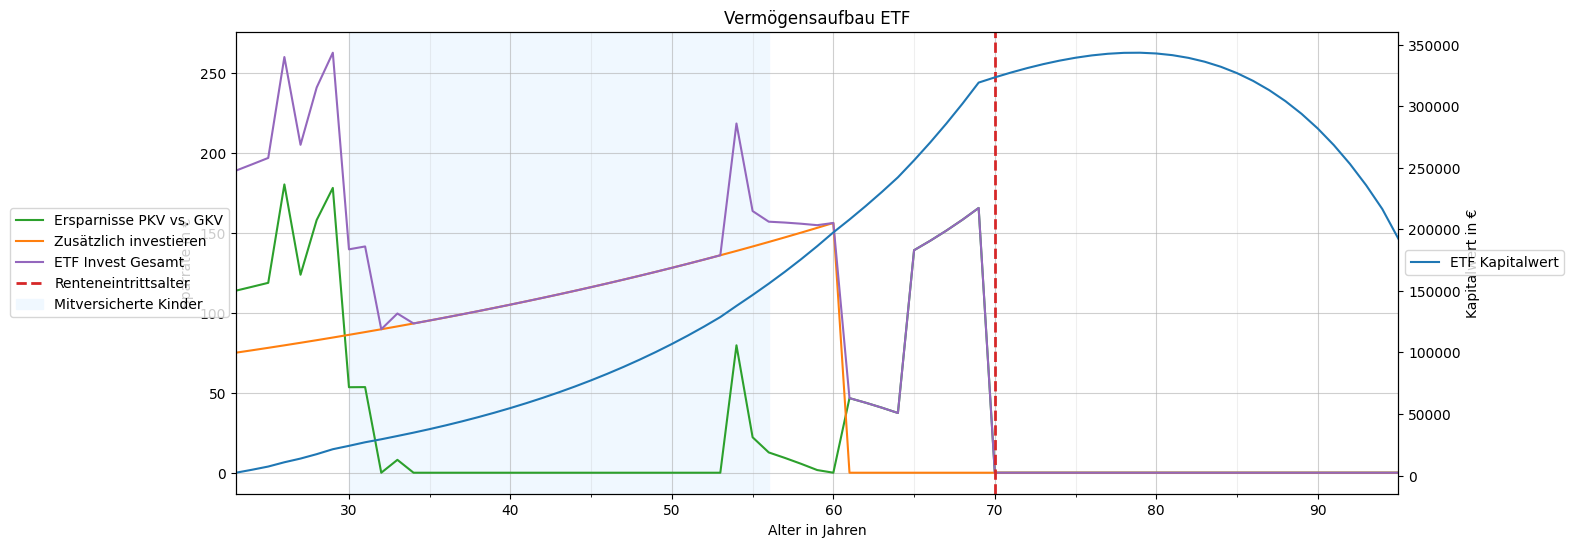

In [179]:
f, ax1 = plt.subplots(1)
f.set_size_inches((15, 6))
ax2 = ax1.twinx()

ax1.plot(df['Alter'], np.maximum(0, df['Ersparnis PKV vs. GKV']), label='Ersparnisse PKV vs. GKV', color='tab:green')
ax1.plot(df['Alter'], df['Zusätzlich investieren'], label='Zusätzlich investieren', color='tab:orange')
ax1.plot(df['Alter'], np.maximum(0, df['Ersparnis PKV vs. GKV']) + df['Zusätzlich investieren'], label='ETF Invest Gesamt', color='tab:purple')

ax1.axvline(x=RENTENEINTRITTSALTER, label="Renteneintrittsalter", linestyle='dashed', color='tab:red', linewidth=2)

if alter_wenn_erstes_kind != 1000:
    ax1.axvspan(alter_wenn_erstes_kind, alter_wenn_letztes_kind, color='aliceblue', label='Mitversicherte Kinder')

ax2.plot(df['Alter'], df['Gebildete Ersparnisse in ETF'], label='ETF Kapitalwert', color='tab:blue')

ax1.set_xlim(left=EINTRITTSALTER)
ax1.set_xlim(right=ENDALTER)

ax1.set_title('Vermögensaufbau ETF')
ax1.set_xlabel('Alter in Jahren')
ax1.set_ylabel('Sparrate in €')
ax2.set_ylabel('Kapitalwert in €')

ax1.set_xticks(major_ticks)
ax1.set_xticks(minor_ticks, minor=True)
ax1.grid(which='minor', alpha=0.2)
ax1.grid(which='major', alpha=0.6)

ax1.legend(loc='center right', bbox_to_anchor=(0, 0.5))
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

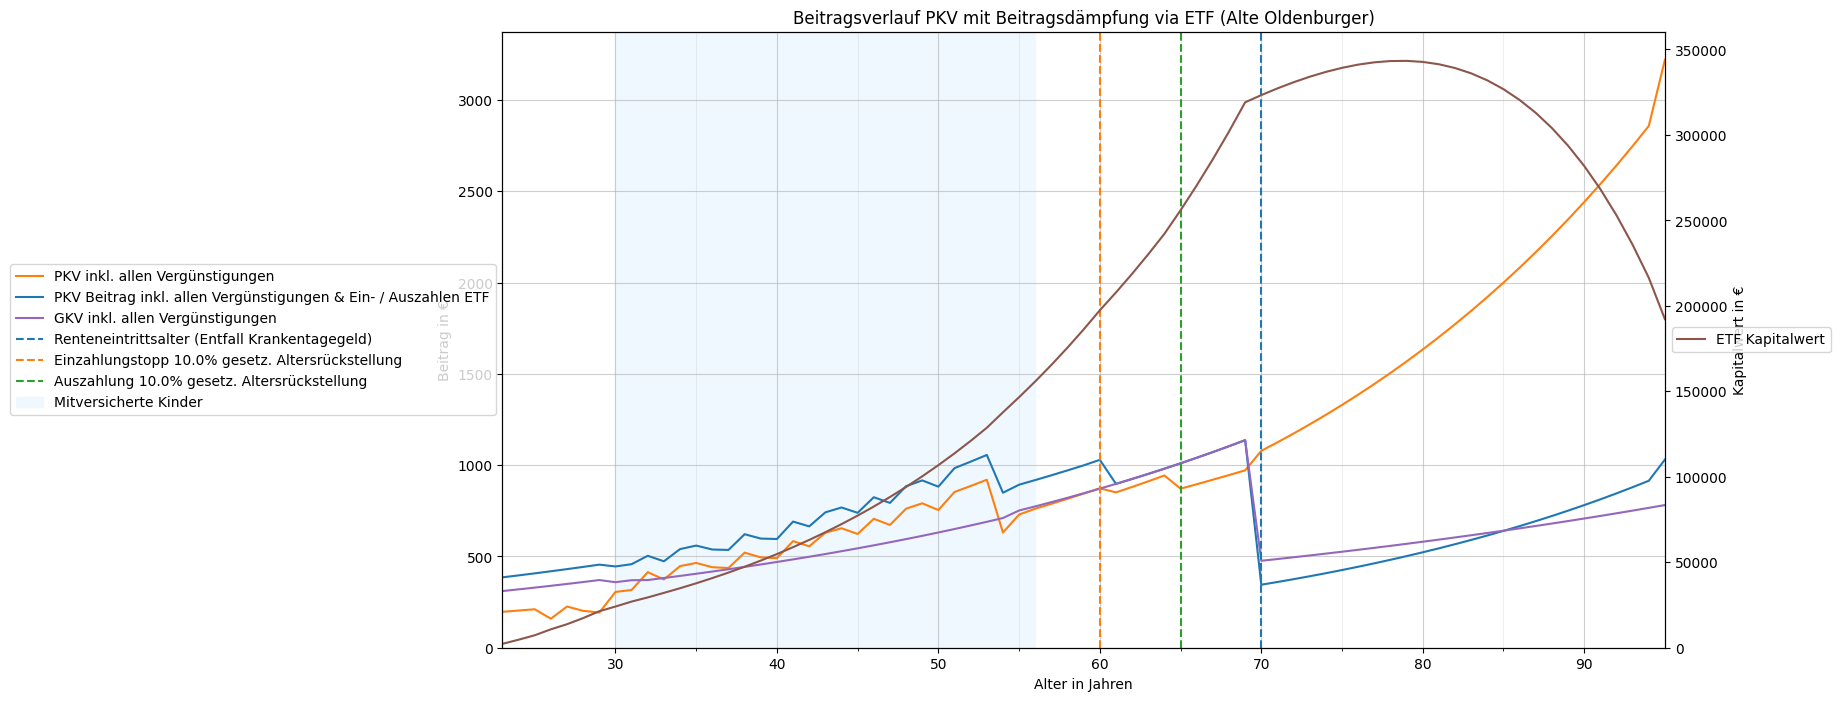

In [180]:
f, ax1 = plt.subplots(1)
f.set_size_inches((15, 8))
ax2 = ax1.twinx()

ax1.plot(df['Alter'], df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE'], label='PKV inkl. allen Vergünstigungen', color='tab:orange')
# ax1.plot(df['Alter'], np.maximum(0, df['Ersparnis PKV vs. GKV']) + df['Zusätzlich investieren'], label='ETF Einzahlen', color='tab:red')
# ax1.plot(df['Alter'], np.maximum(0, df['ETF Auszahlung (nach Steuer)']) + df['Zusätzlich investieren'], label='ETF Auszahlung (nach Steuern)', color='tab:green')
ax1.plot(df['Alter'], df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE inkl. ETF'], label='PKV Beitrag inkl. allen Vergünstigungen & Ein- / Auszahlen ETF', color='tab:blue')
ax1.plot(df['Alter'], df['GKV: Beitrag inkl. Zuschüsse inkl. LS'], label='GKV inkl. allen Vergünstigungen', color='tab:purple')

ax2.plot(df['Alter'], df['Gebildete Ersparnisse in ETF'], label='ETF Kapitalwert', color='tab:brown')

ax1.axvline(x=RENTENEINTRITTSALTER, label="Renteneintrittsalter (Entfall Krankentagegeld)", linestyle='dashed', color='tab:blue')
ax1.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNG_EINZAHLUNG_BIS, label=f'Einzahlungstopp {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:orange')
ax1.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNGSPAKET_WIRKSAM_AB, label=f'Auszahlung {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:green')
if gesetzliche_altersruckstellungen_verbraucht != ENDALTER:
    ax1.axvline(x=gesetzliche_altersruckstellungen_verbraucht, label='gestz. Altersrückstellungen verbraucht', linestyle='dashed', color='tab:red')

if alter_wenn_erstes_kind != 1000:
    ax1.axvspan(alter_wenn_erstes_kind, alter_wenn_letztes_kind, color='aliceblue', label='Mitversicherte Kinder')

ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
ax1.set_xlim(left=EINTRITTSALTER)
ax1.set_xlim(right=ENDALTER)

ax1.set_title(f'Beitragsverlauf PKV mit Beitragsdämpfung via ETF ({PKV_VERSICHERUNG})')
ax1.set_xlabel('Alter in Jahren')
ax1.set_ylabel('Beitrag in €')
ax2.set_ylabel('Kapitalwert in €')

ax1.set_xticks(major_ticks)
ax1.set_xticks(minor_ticks, minor=True)
ax1.grid(which='minor', alpha=0.2)
ax1.grid(which='major', alpha=0.6)

ax1.yaxis.set_major_locator(plt.MultipleLocator(500))

ax1.legend(loc='center right', bbox_to_anchor=(0, 0.5))
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

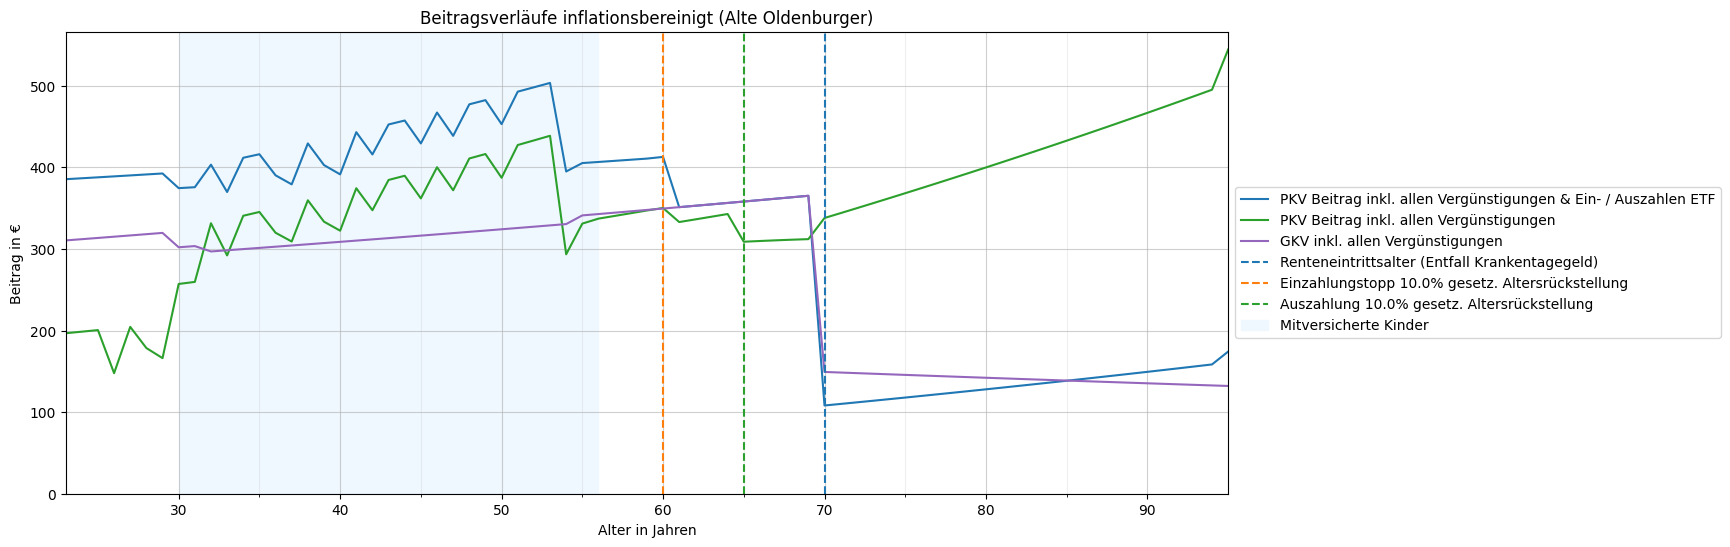

In [181]:
f, ax = plt.subplots(1)
f.set_size_inches((15, 6))

plt.plot(df['Alter'], df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE inkl. ETF inflationsbereinigt'], label='PKV Beitrag inkl. allen Vergünstigungen & Ein- / Auszahlen ETF', color='tab:blue')
plt.plot(df['Alter'], df['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE inflationsbereinigt'], label='PKV Beitrag inkl. allen Vergünstigungen', color='tab:green')
plt.plot(df['Alter'], df['GKV: Beitrag inkl. Zuschüsse inkl. LS inflationsbereinigt'], label='GKV inkl. allen Vergünstigungen', color='tab:purple')

ax.axvline(x=RENTENEINTRITTSALTER, label="Renteneintrittsalter (Entfall Krankentagegeld)", linestyle='dashed', color='tab:blue')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNG_EINZAHLUNG_BIS, label=f'Einzahlungstopp {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:orange')
ax.axvline(x=PKV_GESETZLICHE_BEITRAGSENTLASTUNGSPAKET_WIRKSAM_AB, label=f'Auszahlung {PKV_GESETZLICHE_BEITRAGSENTLASTUNG_ANTEIL * 100}% gesetz. Altersrückstellung', linestyle='dashed', color='tab:green')
if gesetzliche_altersruckstellungen_verbraucht != ENDALTER:
    ax.axvline(x=gesetzliche_altersruckstellungen_verbraucht, label='gestz. Altersrückstellungen verbraucht', linestyle='dashed', color='tab:red')

if alter_wenn_erstes_kind != 1000:
    ax.axvspan(alter_wenn_erstes_kind, alter_wenn_letztes_kind, color='aliceblue', label='Mitversicherte Kinder')

ax.set_ylim(bottom=0)
ax.set_xlim(left=EINTRITTSALTER)
ax.set_xlim(right=ENDALTER)

ax.set_title(f'Beitragsverläufe inflationsbereinigt ({PKV_VERSICHERUNG})')
ax.set_xlabel('Alter in Jahren')
ax.set_ylabel('Beitrag in €')

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.6)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Gesamtkosten inflationsbereinigt

In [182]:
def foo_summen(df):
    return (df[[
        'PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE inflationsbereinigt',
        'PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE inkl. ETF inflationsbereinigt',
        'GKV: Beitrag inkl. Zuschüsse inkl. LS inflationsbereinigt',
    ]] * 12).sum()

summen = foo_summen(df)
summen

PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE inflationsbereinigt                     312,570.7223
PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE inkl. ETF inflationsbereinigt           271,577.8859
GKV: Beitrag inkl. Zuschüsse inkl. LS inflationsbereinigt                                               227,555.4791
dtype: float64

In [183]:
teurer_prozent = ((summen['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE inkl. ETF inflationsbereinigt'] / summen['GKV: Beitrag inkl. Zuschüsse inkl. LS inflationsbereinigt']) - 1) * 100
print(f'Die PKV ist gesamtheitlich gesehen {int(teurer_prozent * 100) / 100}% teurer als die GKV')

Die PKV ist gesamtheitlich gesehen 19.34% teurer als die GKV


In [184]:
def foo_etf_restwert(df):
    return df.tail(1)['Gebildete Ersparnisse in ETF'].iloc[0] / df.tail(1)[f'Inflation seit {JAHR}'].iloc[0]

restwert_etf_inflationsbereinigt = foo_etf_restwert(df)
print(f'Restwert ETF inflationsbereinigt (Alter: {ENDALTER} Jahre): {math.floor(restwert_etf_inflationsbereinigt)}€')

Restwert ETF inflationsbereinigt (Alter: 95 Jahre): 32478€


# Optimieren

In [185]:
def foo_all(
        pkv_beitragsentlastungspaket_einzahlen_ab,
        on_top_investieren_betrag
    ):
    df1 = pd.DataFrame()
    df1 = foo1(df1)
    df1, _, _ = foo2(df1)
    df1 = foo3(df1, pkv_beitragsentlastungspaket_einzahlen_ab)
    df1 = foo4(df1, on_top_investieren_betrag)
    summen1 = foo_summen(df1)
    return summen1['PKV: Beitrag Gesamt inkl. Zuschüsse inkl. LS inkl. AR inkl. BRE inkl. ETF inflationsbereinigt'], foo_etf_restwert(df1)

s, r = foo_all(
    PKV_BEITRAGSENTLASTUNGSPAKET_EINZAHLEN_AB,
    ON_TOP_INVESTIEREN_BETRAG
)
r, s, s - r

(32478.277725302425, 271577.885884574, 239099.60815927153)

In [186]:
raise SystemExit("Stop right there!")

SystemExit: Stop right there!

/home/maxileith/pkv-kosten/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [121]:
best_summe = 99999999999
best_parameters = {}
for pkv_beitragsentlastungspaket_einzahlen_ab in range (EINTRITTSALTER, 55):
    for on_top_investieren_betrag in range(25, 150 + 1, 25):
        s, r = foo_all(
            pkv_beitragsentlastungspaket_einzahlen_ab,
            on_top_investieren_betrag,
        )
        if r > 50000:
            continue
        if math.floor(s - r) <= math.floor(best_summe):
            best_summe = s - r
            best_parameters = {
                'pkv_beitragsentlastungspaket_einzahlen_ab': pkv_beitragsentlastungspaket_einzahlen_ab,
                'on_top_investieren_betrag': on_top_investieren_betrag,
        	}
best_parameters, best_summe

({'pkv_beitragsentlastungspaket_einzahlen_ab': 54,
  'on_top_investieren_betrag': 75},
 239099.60815927153)